## Part I
The given problem.

### Configuration
Change stuff in config.yaml.

In [1]:
#barrowed from module_2_demos (as most implementation in this assignment - see behlow)
import requests
import os.path
import math
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [82]:
import yaml

with open("config.yaml") as file:
    config = yaml.safe_load(file)

sources = config.get("defect_data_sources")
selection = config.get("pick_defect_data_from")
source = sources[selection]


### Get the raw data
Saving it in the `cache/` folder.

In [13]:
from datetime import datetime, timedelta

# get stuff from config
url = source["url"]
product = source["product"]
#file_name = config.get("raw_defect_data")
days = config.get("get_defect_data_going_back_days")

# Function to download and cache data files to csv based on yaml config
def get_raw_data(file_name, url, product, days):
    # update url with search thing since no REST API available
    data_url=url + "/buglist.cgi"

    # Date window as an absolute date (safer than "-Xd" for some instances)
    since = (datetime.utcnow() - timedelta(days=days)).strftime("%Y-%m-%d")
    
    # Changed implementation to repeated tuples since I was only getting 1000 status NEW issues
    # This works (thanks ChatGPT)
    data_params = [
        ("product", product),
        ("query_format", "advanced"),
        ("bug_status", "NEW"),
        ("bug_status", "ASSIGNED"),
        ("bug_status", "REOPENED"),
        ("bug_status", "RESOLVED"),
        ("bug_status", "CLOSED"),
        ("chfield", "[Bug creation]"),
        ("chfieldfrom", since),
        ("chfieldto", "Now"),
        ("limit", "0"),
        ("ctype", "csv"),
        ("columnlist", "bug_id,product,component,assigned_to,bug_status,resolution,severity,bug_severity,opendate,changeddate"),
        ("order", "bug_id DESC"),
    ]
    print("Downloading fresh data to {}".format(file_name))
    r = requests.get(data_url, params=data_params)
    with open(file_name, "w") as f:
        f.write(r.text)

# Make raw data into pandas dataframe
def get_data(bugzilla_url, product, days):
    filename = "data_{}_{}.csv".format(product,days)
    get_raw_data(filename, bugzilla_url, product, days)
    print('Data download complete')
    df = pd.read_csv(filename, header=0, parse_dates=["opendate", "changeddate"])
    return df

RAW_DATA = get_data(url, product, days)

Data download complete


### Base Measures

In [21]:
# Look in df to see the total number of resolved issues/entries
base_measure_total_resolved_issues = len(RAW_DATA[(RAW_DATA["bug_status"] == "RESOLVED") | (RAW_DATA["bug_status"] == "CLOSED")])
print("Total number of resolved issues:", base_measure_total_resolved_issues)

# Look in the df to see how many issues there are in total
base_measure_total_issues = len(RAW_DATA)
print("Total number of issues:", base_measure_total_issues)

# Look in the df to see how many of these issues were not bugs (i.e., enhancements)
base_measure_total_resolved_non_bugs = len(RAW_DATA[((RAW_DATA["bug_status"] == "RESOLVED") | (RAW_DATA["bug_status"] == "CLOSED")) & (RAW_DATA["bug_severity"]=="enhancement")])
print("Total number of resolved non-bugs:", base_measure_total_resolved_non_bugs)

# Save curated data for further analysis
CURATED_DATA_FILE = "base_measure_bugs_{}_{}.csv".format(product,days)

# Create df for base measures
CURATED_DATA = RAW_DATA[((RAW_DATA["bug_status"] == "RESOLVED") | (RAW_DATA["bug_status"] == "CLOSED")) & (RAW_DATA["bug_severity"]!="enhancement")]
CURATED_DATA.to_csv(CURATED_DATA_FILE, index=False)
print("Curated data saved to {}".format(CURATED_DATA_FILE))

# Save curated data for further analysis
CURATED_DATA_FILE = "base_measure_non_bugs_{}_{}.csv".format(product,days)

# Create df for base measures
CURATED_DATA = RAW_DATA[((RAW_DATA["bug_status"] == "RESOLVED") | (RAW_DATA["bug_status"] == "CLOSED")) & (RAW_DATA["bug_severity"]=="enhancement")]
CURATED_DATA.to_csv(CURATED_DATA_FILE, index=False)
print("Curated data saved to {}".format(CURATED_DATA_FILE))

Total number of resolved issues: 1089
Total number of issues: 1792
Total number of resolved non-bugs: 49
Curated data saved to base_measure_bugs_gcc_180.csv
Curated data saved to base_measure_non_bugs_gcc_180.csv


In [22]:
# function to return df with new issues per day 
def get_new_issues_per_day(df):
    # Create a date range from the earliest to the latest opendate
    start_date = df['opendate'].min().date()
    end_date = df['opendate'].max().date()
    date_range = pd.date_range(start=start_date, end=end_date)

    # Initialize a list to hold the counts
    new_issues_counts = []

    # Loop through each date in the range and count new issues
    for single_date in date_range:
        count = df[df['opendate'].dt.date == single_date.date()].shape[0]
        new_issues_counts.append({'date': single_date.date(), 'new_issues': count})

    # Convert the list of counts to a DataFrame
    new_issues_df = pd.DataFrame(new_issues_counts)
    return new_issues_df

NEW_ISSUES_DF = get_new_issues_per_day(RAW_DATA)
NEW_ISSUES_DF.to_csv("new_issues_per_day_{}_{}.csv".format(product,days), index=False)
print("New issues per day data saved to new_issues_per_day_{}_{}.csv".format(product,days))


New issues per day data saved to new_issues_per_day_gcc_180.csv


In [23]:
# function to return df with resolved issues per day 
def get_resolved_issues_per_day(df):
    # Create a date range from the earliest to the latest changeddate
    start_date = df['changeddate'].min().date()
    end_date = df['changeddate'].max().date()
    date_range = pd.date_range(start=start_date, end=end_date)

    # Initialize a list to hold the counts
    resolved_issues_counts = []

    # Loop through each date in the range and count resolved issues
    for single_date in date_range:
        count = df[(df['changeddate'].dt.date == single_date.date()) & 
                   ((df['bug_status'] == 'RESOLVED') | (df['bug_status'] == 'CLOSED'))].shape[0]
        resolved_issues_counts.append({'date': single_date.date(), 'resolved_issues': count})

    # Convert the list of counts to a DataFrame
    resolved_issues_df = pd.DataFrame(resolved_issues_counts)
    return resolved_issues_df

RESOLVED_ISSUES_DF = get_resolved_issues_per_day(RAW_DATA)
RESOLVED_ISSUES_DF.to_csv("resolved_issues_per_day_{}_{}.csv".format(product,days), index=False)
print("Resolved issues per day data saved to resolved_issues_per_day_{}_{}.csv".format(product,days))

Resolved issues per day data saved to resolved_issues_per_day_gcc_180.csv


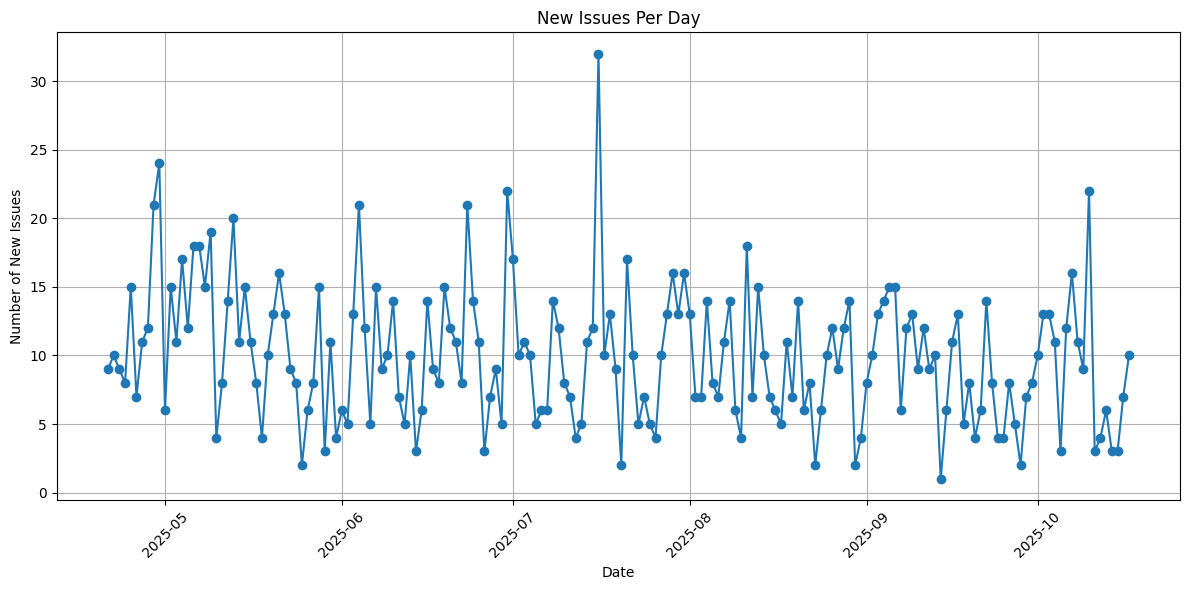

In [24]:
# Visualize the new issues per day
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(NEW_ISSUES_DF['date'], NEW_ISSUES_DF['new_issues'], marker='o', linestyle='-')
plt.title('New Issues Per Day')
plt.xlabel('Date')
plt.ylabel('Number of New Issues')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


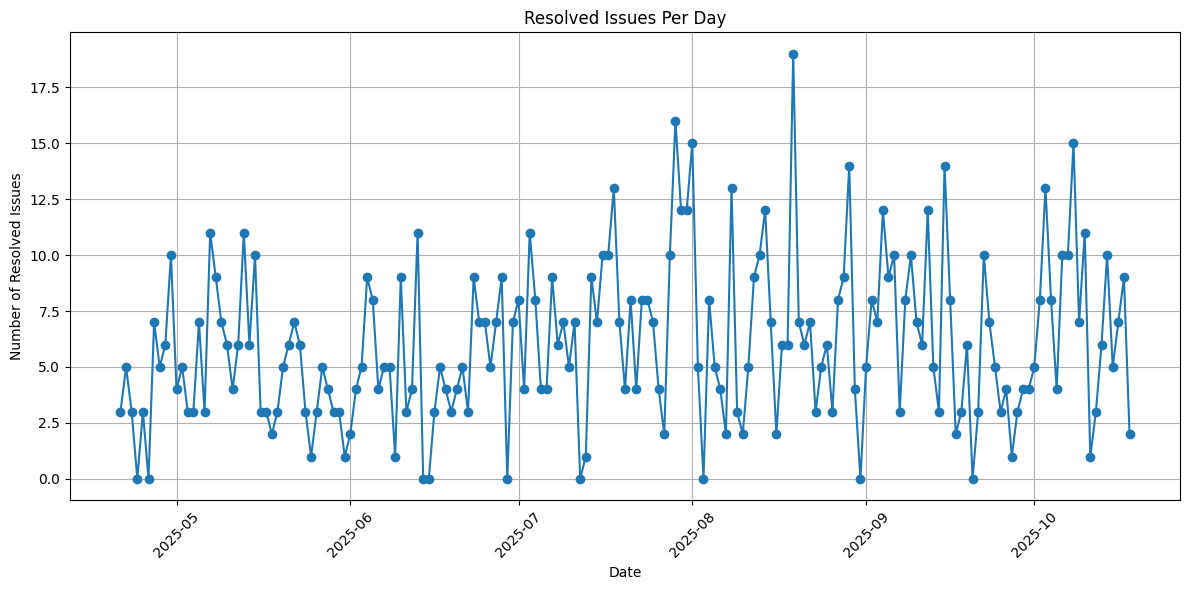

In [25]:
# Visualize resolved issues per day
plt.figure(figsize=(12, 6))
plt.plot(RESOLVED_ISSUES_DF['date'], RESOLVED_ISSUES_DF['resolved_issues'], marker='o', linestyle='-')
plt.title('Resolved Issues Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Resolved Issues')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [26]:
# function that returns a df with the resultion time per issue
def get_resolution_time_df(df):
    # Filter for resolved or closed issues
    resolved_df = df[(df['bug_status'] == 'RESOLVED') | (df['bug_status'] == 'CLOSED')].copy()
    
    # Calculate resolution time in days
    resolved_df['resolution_time_days'] = (resolved_df['changeddate'] - resolved_df['opendate']).dt.total_seconds() / (24 * 3600)
    
    # Select relevant columns
    resolution_time_df = resolved_df[['bug_id', 'opendate', 'changeddate', 'resolution_time_days']]
    
    return resolution_time_df

RESOLUTION_TIME_DF = get_resolution_time_df(RAW_DATA)
RESOLUTION_TIME_DF.to_csv("resolution_time_{}_{}.csv".format(product,days), index=False)
print("Resolution time data saved to resolution_time_{}_{}.csv".format(product,days))

Resolution time data saved to resolution_time_gcc_180.csv


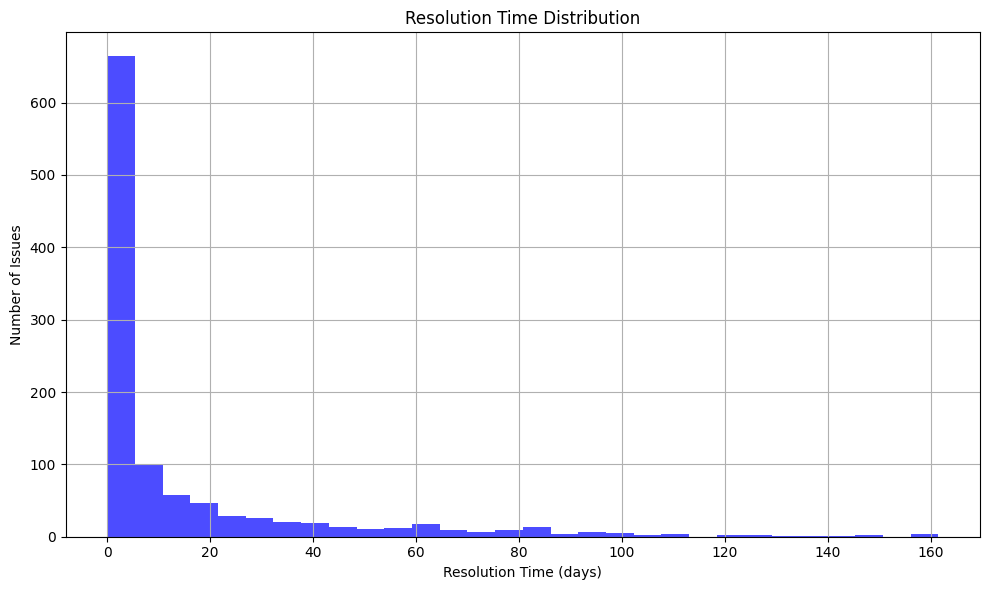

In [28]:
# function that visualizes the resolution time distribution
def plot_resolution_time_distribution(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['resolution_time_days'], bins=30, color='blue', alpha=0.7)
    plt.title('Resolution Time Distribution')
    plt.xlabel('Resolution Time (days)')
    plt.ylabel('Number of Issues')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_resolution_time_distribution(RESOLUTION_TIME_DF)

### Derived Measures

In [29]:
# Function to calculate average resolution time
def calculate_average_resolution_time(df):
    average_time = df['resolution_time_days'].mean()
    return average_time
average_resolution_time = calculate_average_resolution_time(RESOLUTION_TIME_DF)
print("Average resolution time (days):", average_resolution_time)

Average resolution time (days): 14.651098187259803


In [43]:
# Function to predict future resolution times based on historical average
def predict_future_resolution_times(df, num_predictions):
    avg = float(calculate_average_resolution_time(df))  # cast to py float
    return [avg] * num_predictions

# Function to predict future new issues based on historical data using moving average
def predict_future_new_issues(df, num_predictions, window_size=7):
    # Work on a copy to avoid side effects
    s = pd.to_numeric(df['new_issues'], errors='coerce')

    # Strict rolling window; only produce means when the window is complete
    ma = s.rolling(window=window_size, min_periods=window_size).mean()

    # If we have at least one full-window mean, use the last one; otherwise fallback to simple mean
    last_ma = ma.dropna().iloc[-1] if ma.notna().any() else s.mean()

    val = float(last_ma)  # cast to py float
    return [val] * num_predictions

# Predict future resolution times for the next 10 issues
future_resolution_time_predictions = predict_future_resolution_times(RESOLUTION_TIME_DF, 10)
print("Predicted resolution times for next 10 issues (days):", future_resolution_time_predictions)

# Predict future new issues for the next 10 days
future_new_issue_predictions = predict_future_new_issues(NEW_ISSUES_DF, 10)
print("Predicted new issues for next 10 days:", format(future_new_issue_predictions))

Predicted resolution times for next 10 issues (days): [14.651098187259803, 14.651098187259803, 14.651098187259803, 14.651098187259803, 14.651098187259803, 14.651098187259803, 14.651098187259803, 14.651098187259803, 14.651098187259803, 14.651098187259803]
Predicted new issues for next 10 days: [5.142857142857143, 5.142857142857143, 5.142857142857143, 5.142857142857143, 5.142857142857143, 5.142857142857143, 5.142857142857143, 5.142857142857143, 5.142857142857143, 5.142857142857143]


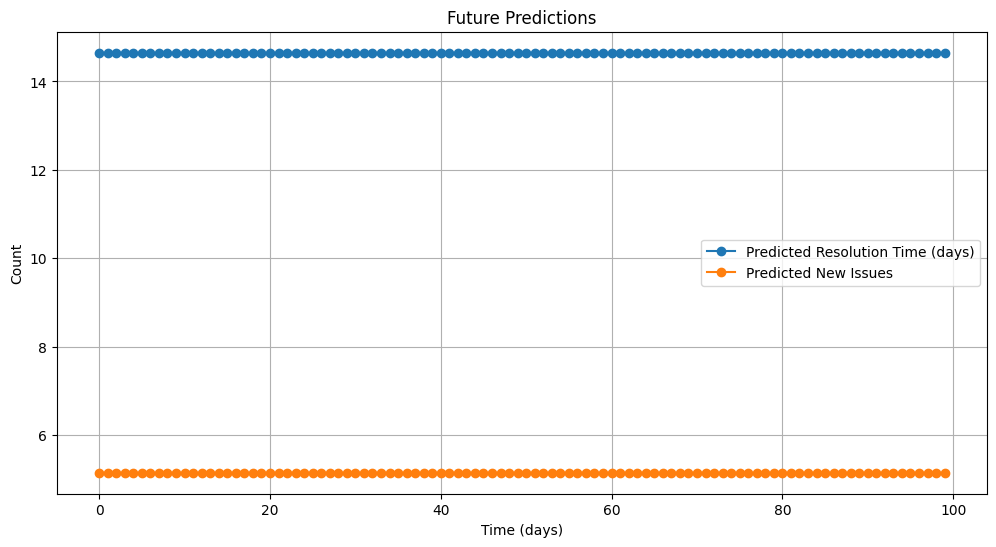

In [35]:
# visualize the two predictions together
plt.figure(figsize=(12, 6))
plt.plot(future_resolution_time_predictions, label='Predicted Resolution Time (days)', marker='o')
plt.plot(future_new_issue_predictions, label='Predicted New Issues', marker='o')
plt.title('Future Predictions')
plt.xlabel('Time (days)')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()

In [47]:

# Backlog size at the end of the data period
total_unresolved = RAW_DATA[~RAW_DATA['bug_status'].isin(['RESOLVED', 'CLOSED'])].shape[0]
print("Total unresolved issues at the end of the data period:", total_unresolved)

# Function to predict future unresolved issues based on current backlog, predicted resolutions and inflow
def predict_future_unresolved_issues(current_unresolved, predicted_resolution_times, predicted_new_issues):
    
    # Calculate resolved issues per day from predicted resolution times
    predicted_resolutions = [math.floor(1 / rt) if rt > 0 else 0 for rt in predicted_resolution_times]
    
    future_unresolved = []
    unresolved = current_unresolved
    for resolved, new_issues in zip(predicted_resolutions, predicted_new_issues):
        unresolved = unresolved - resolved + new_issues
        future_unresolved.append(unresolved)
    return future_unresolved
future_unresolved = predict_future_unresolved_issues(total_unresolved, future_resolution_time_predictions, future_new_issue_predictions)
print("Predicted unresolved issues for next 10 days:", future_unresolved)



Total unresolved issues at the end of the data period: 703
Predicted unresolved issues for next 10 days: [708.1428571428571, 713.2857142857142, 718.4285714285713, 723.5714285714284, 728.7142857142856, 733.8571428571427, 738.9999999999998, 744.1428571428569, 749.285714285714, 754.4285714285711]


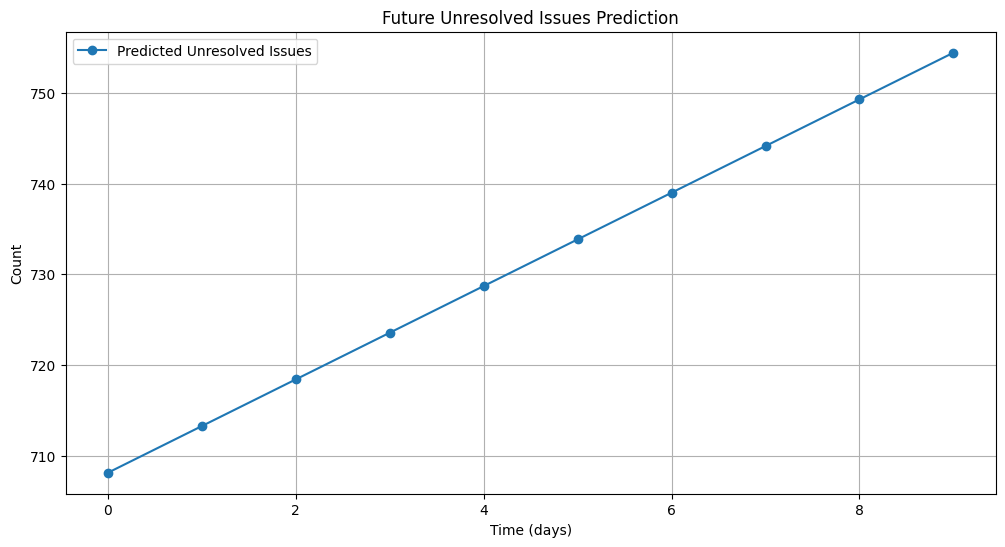

In [48]:
# Visualize future unresolved issues
plt.figure(figsize=(12, 6))
plt.plot(future_unresolved, label='Predicted Unresolved Issues', marker='o')
plt.title('Future Unresolved Issues Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()

In [60]:
# Function to calculate fraction of enhancements / other issues among unresolved issues per day
def calculate_fraction_unresolved_non_bugs(df):
    unresolved_df = df[~df['bug_status'].isin(['RESOLVED', 'CLOSED'])]
    total_unresolved = unresolved_df.shape[0]
    if total_unresolved == 0:
        return 0.0
    unresolved_non_bugs = unresolved_df[unresolved_df['bug_severity'] == 'enhancement'].shape[0]
    fraction = unresolved_non_bugs / total_unresolved
    return fraction

fraction_unresolved_non_bugs = calculate_fraction_unresolved_non_bugs(RAW_DATA)
print("Fraction of unresolved non-bugs among unresolved issues:", fraction_unresolved_non_bugs)

# Function to calculate historical fraction of non-bugs over time
def calculate_historical_non_bug_fraction(df):
    # Group by date and calculate daily fraction
    df_copy = df.copy()
    df_copy['date'] = df_copy['opendate'].dt.date
    
    daily_fractions = []
    for date in df_copy['date'].unique():
        daily_issues = df_copy[df_copy['date'] == date]
        total_daily = len(daily_issues)
        non_bugs_daily = len(daily_issues[daily_issues['bug_severity'] == 'enhancement'])
        fraction = non_bugs_daily / total_daily if total_daily > 0 else 0
        daily_fractions.append({'date': date, 'fraction_non_bugs': fraction})
    
    return pd.DataFrame(daily_fractions).sort_values('date')

historical_fractions = calculate_historical_non_bug_fraction(RAW_DATA)
print(f"Historical non-bug fraction - Mean: {historical_fractions['fraction_non_bugs'].mean():.3f}, "
      f"Std: {historical_fractions['fraction_non_bugs'].std():.3f}")

# FIXED: Function to predict future non-bug fraction (simple approaches)
def predict_future_non_bug_fraction(historical_fractions_df, current_unresolved_fraction, num_predictions, method='constant'):
    """
    Predict future non-bug fraction using different methods:
    - 'constant': Use CURRENT UNRESOLVED fraction (not last daily fraction)
    - 'trend': Use linear trend from historical data
    - 'moving_average': Use moving average
    """
    
    if method == 'constant':
        # FIXED: Use the current unresolved fraction, not the last daily fraction
        return [current_unresolved_fraction] * num_predictions
    
    elif method == 'trend':
        # Fit a simple linear trend
        x = np.arange(len(historical_fractions_df))
        y = historical_fractions_df['fraction_non_bugs'].values
        
        # Simple linear regression
        slope, intercept = np.polyfit(x, y, 1)
        
        # Predict future values
        future_x = np.arange(len(historical_fractions_df), len(historical_fractions_df) + num_predictions)
        future_fractions = slope * future_x + intercept
        
        # Clamp between 0 and 1
        future_fractions = np.clip(future_fractions, 0, 1)
        return future_fractions.tolist()
    
    elif method == 'moving_average':
        # Use moving average of last N days (but exclude days with 0 issues)
        window_size = min(7, len(historical_fractions_df))
        
        # Filter out days with 0 issues for a more meaningful average
        non_zero_fractions = historical_fractions_df[historical_fractions_df['fraction_non_bugs'] >= 0]['fraction_non_bugs']
        if len(non_zero_fractions) > 0:
            recent_avg = non_zero_fractions.tail(window_size).mean()
        else:
            recent_avg = current_unresolved_fraction
        
        return [recent_avg] * num_predictions
    
    else:
        raise ValueError("Method must be 'constant', 'trend', or 'moving_average'")

# FIXED: Try different prediction methods with the current unresolved fraction
future_fraction_constant = predict_future_non_bug_fraction(historical_fractions, fraction_unresolved_non_bugs, 10, 'constant')
future_fraction_trend = predict_future_non_bug_fraction(historical_fractions, fraction_unresolved_non_bugs, 10, 'trend')
future_fraction_ma = predict_future_non_bug_fraction(historical_fractions, fraction_unresolved_non_bugs, 10, 'moving_average')

print("Predicted non-bug fractions (constant):", [f"{x:.3f}" for x in future_fraction_constant])
print("Predicted non-bug fractions (trend):", [f"{x:.3f}" for x in future_fraction_trend])
print("Predicted non-bug fractions (moving avg):", [f"{x:.3f}" for x in future_fraction_ma])

# Function to predict future non-bug unresolved issues
def predict_future_non_bug_unresolved_issues(future_unresolved, future_fraction_non_bugs):
    future_non_bug_unresolved = []
    for unresolved, fraction in zip(future_unresolved, future_fraction_non_bugs):
        non_bug_unresolved = unresolved * fraction
        future_non_bug_unresolved.append(non_bug_unresolved)
    return future_non_bug_unresolved

# Calculate predictions using the FIXED constant method
future_non_bug_unresolved = predict_future_non_bug_unresolved_issues(future_unresolved, future_fraction_constant)
print("Predicted non-bug unresolved issues for next 10 days:", [f"{x:.1f}" for x in future_non_bug_unresolved])

Fraction of unresolved non-bugs among unresolved issues: 0.1465149359886202
Historical non-bug fraction - Mean: 0.087, Std: 0.116
Predicted non-bug fractions (constant): ['0.147', '0.147', '0.147', '0.147', '0.147', '0.147', '0.147', '0.147', '0.147', '0.147']
Predicted non-bug fractions (trend): ['0.119', '0.119', '0.120', '0.120', '0.120', '0.121', '0.121', '0.121', '0.122', '0.122']
Predicted non-bug fractions (moving avg): ['0.104', '0.104', '0.104', '0.104', '0.104', '0.104', '0.104', '0.104', '0.104', '0.104']
Predicted non-bug unresolved issues for next 10 days: ['103.8', '104.5', '105.3', '106.0', '106.8', '107.5', '108.3', '109.0', '109.8', '110.5']


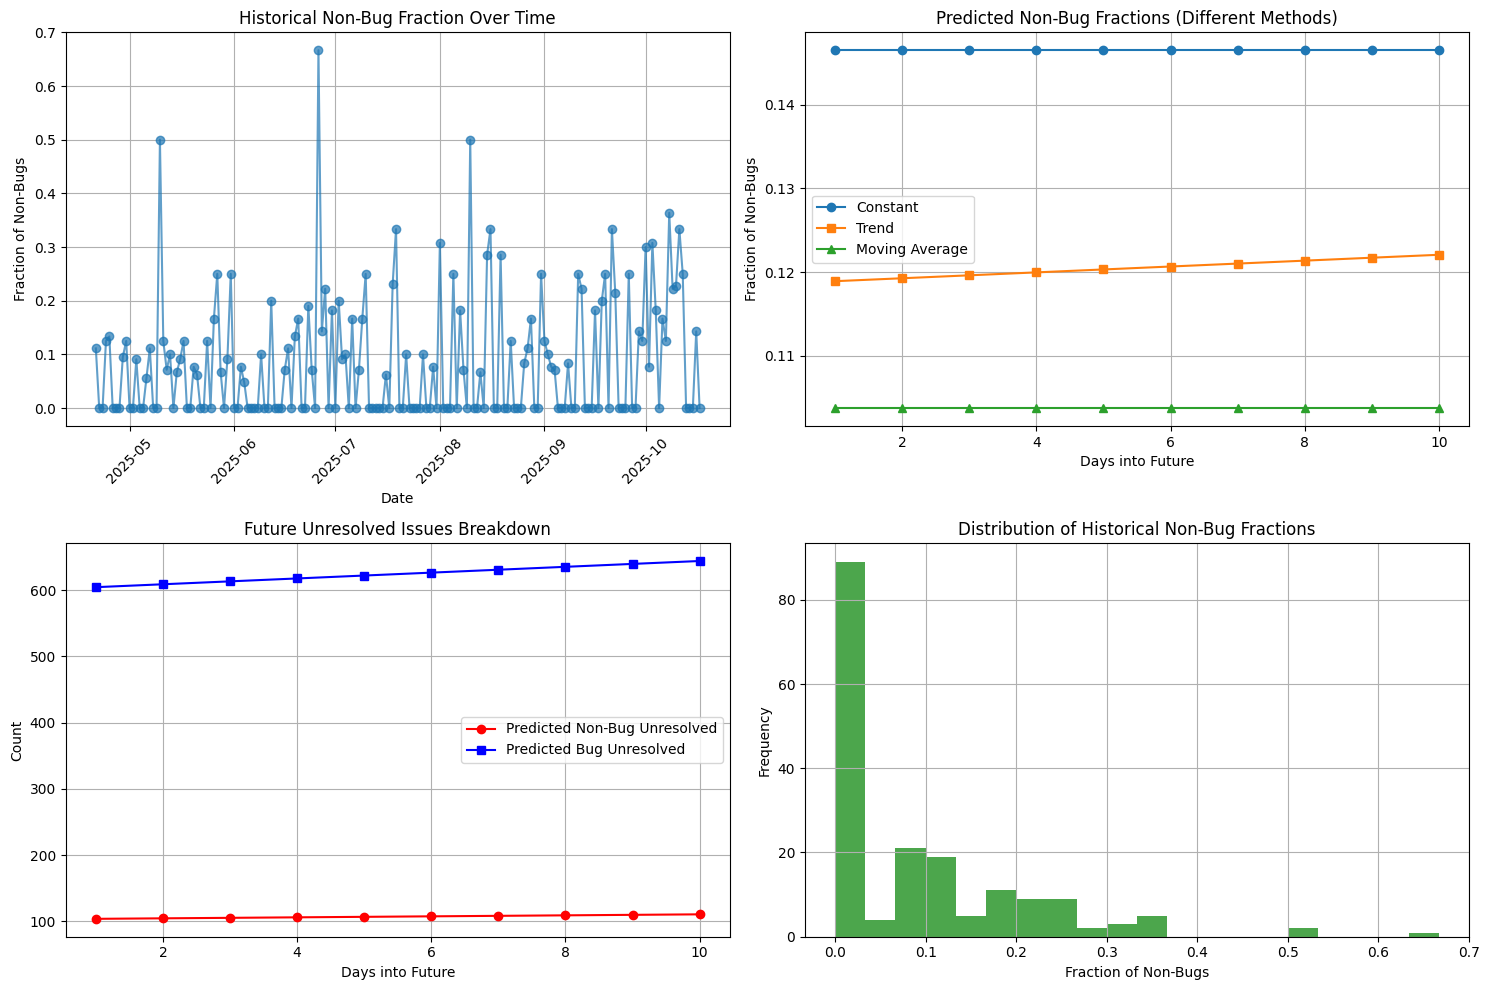


=== SUMMARY STATISTICS ===
Current unresolved issues: 703
Current non-bug fraction: 0.147
Historical non-bug fraction (mean ± std): 0.087 ± 0.116
Predicted non-bug unresolved in 10 days: 110.5
Predicted total unresolved in 10 days: 754.4
Predicted workload split in 10 days: 14.7% non-bugs, 85.3% bugs


In [61]:
# Visualize historical and predicted non-bug fractions
plt.figure(figsize=(15, 10))

# Subplot 1: Historical non-bug fraction over time
plt.subplot(2, 2, 1)
plt.plot(historical_fractions['date'], historical_fractions['fraction_non_bugs'], marker='o', alpha=0.7)
plt.title('Historical Non-Bug Fraction Over Time')
plt.xlabel('Date')
plt.ylabel('Fraction of Non-Bugs')
plt.xticks(rotation=45)
plt.grid()

# Subplot 2: Comparison of prediction methods
plt.subplot(2, 2, 2)
days = range(1, 11)
plt.plot(days, future_fraction_constant, label='Constant', marker='o')
plt.plot(days, future_fraction_trend, label='Trend', marker='s')
plt.plot(days, future_fraction_ma, label='Moving Average', marker='^')
plt.title('Predicted Non-Bug Fractions (Different Methods)')
plt.xlabel('Days into Future')
plt.ylabel('Fraction of Non-Bugs')
plt.legend()
plt.grid()

# Subplot 3: Future non-bug unresolved issues
plt.subplot(2, 2, 3)
plt.plot(days, future_non_bug_unresolved, label='Predicted Non-Bug Unresolved', marker='o', color='red')
plt.plot(days, [total - non_bug for total, non_bug in zip(future_unresolved, future_non_bug_unresolved)], 
         label='Predicted Bug Unresolved', marker='s', color='blue')
plt.title('Future Unresolved Issues Breakdown')
plt.xlabel('Days into Future')
plt.ylabel('Count')
plt.legend()
plt.grid()

# Subplot 4: Distribution of historical fractions
plt.subplot(2, 2, 4)
plt.hist(historical_fractions['fraction_non_bugs'], bins=20, alpha=0.7, color='green')
plt.title('Distribution of Historical Non-Bug Fractions')
plt.xlabel('Fraction of Non-Bugs')
plt.ylabel('Frequency')
plt.grid()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Current unresolved issues: {total_unresolved}")
print(f"Current non-bug fraction: {fraction_unresolved_non_bugs:.3f}")
print(f"Historical non-bug fraction (mean ± std): {historical_fractions['fraction_non_bugs'].mean():.3f} ± {historical_fractions['fraction_non_bugs'].std():.3f}")
print(f"Predicted non-bug unresolved in 10 days: {future_non_bug_unresolved[-1]:.1f}")
print(f"Predicted total unresolved in 10 days: {future_unresolved[-1]:.1f}")
print(f"Predicted workload split in 10 days: {future_non_bug_unresolved[-1]/future_unresolved[-1]*100:.1f}% non-bugs, {(1-future_non_bug_unresolved[-1]/future_unresolved[-1])*100:.1f}% bugs")

### Indicators
Showing current and predicted indicator for fraction of non-bug / bug work.

In [77]:
# Traffic light indicator based on YAML file settings for fraction of non-bug / bug work
def traffic_light_indicator(value, thresholds):
    """
    Returns traffic light color based on non-bug fraction thresholds
    GREEN: Low non-bug fraction (≤ 10% - mostly bug fixes, good!)
    YELLOW: Moderate non-bug fraction (10-33% - balanced workload)
    RED: High non-bug fraction (> 33% - too much enhancement work, focus on bugs!)
    """
    if value <= thresholds['green']:
        return 'GREEN'
    elif value <= thresholds['yellow']:
        return 'YELLOW'
    else:
        return 'RED'

# Get thresholds from config
thresholds = config['indicators']['non_bug_fraction']

# Calculate indicators
current_indicator = traffic_light_indicator(fraction_unresolved_non_bugs, thresholds)
predicted_fraction = future_non_bug_unresolved[-1] / future_unresolved[-1]
predicted_indicator = traffic_light_indicator(predicted_fraction, thresholds)

# Display results
print("=== TRAFFIC LIGHT INDICATORS ===")
print(f"Current non-bug fraction: {fraction_unresolved_non_bugs:.3f} ({fraction_unresolved_non_bugs*100:.1f}%) → {current_indicator}")
print(f"Predicted non-bug fraction: {predicted_fraction:.3f} ({predicted_fraction*100:.1f}%) → {predicted_indicator}")

print(f"\nThresholds (for non-bug work):")
print(f"  GREEN: ≤ {thresholds['green']*100:.0f}% non-bug work (focus on bug fixes)")
print(f"  YELLOW: {thresholds['green']*100:.0f}% - {thresholds['yellow']*100:.0f}% non-bug work (balanced workload)")
print(f"  RED: > {thresholds['yellow']*100:.0f}% non-bug work (too much enhancement work)")

print(f"\nEquivalent thresholds (for bug work):")
print(f"  GREEN: ≥ {(1-thresholds['green'])*100:.0f}% bug work (good - mostly fixing bugs)")  
print(f"  YELLOW: {(1-thresholds['yellow'])*100:.0f}% - {(1-thresholds['green'])*100:.0f}% bug work (balanced)")
print(f"  RED: < {(1-thresholds['yellow'])*100:.0f}% bug work (bad - too little bug fixing)")

=== TRAFFIC LIGHT INDICATORS ===
Current non-bug fraction: 0.147 (14.7%) → YELLOW
Predicted non-bug fraction: 0.147 (14.7%) → YELLOW

Thresholds (for non-bug work):
  GREEN: ≤ 10% non-bug work (focus on bug fixes)
  YELLOW: 10% - 33% non-bug work (balanced workload)
  RED: > 33% non-bug work (too much enhancement work)

Equivalent thresholds (for bug work):
  GREEN: ≥ 90% bug work (good - mostly fixing bugs)
  YELLOW: 67% - 90% bug work (balanced)
  RED: < 67% bug work (bad - too little bug fixing)


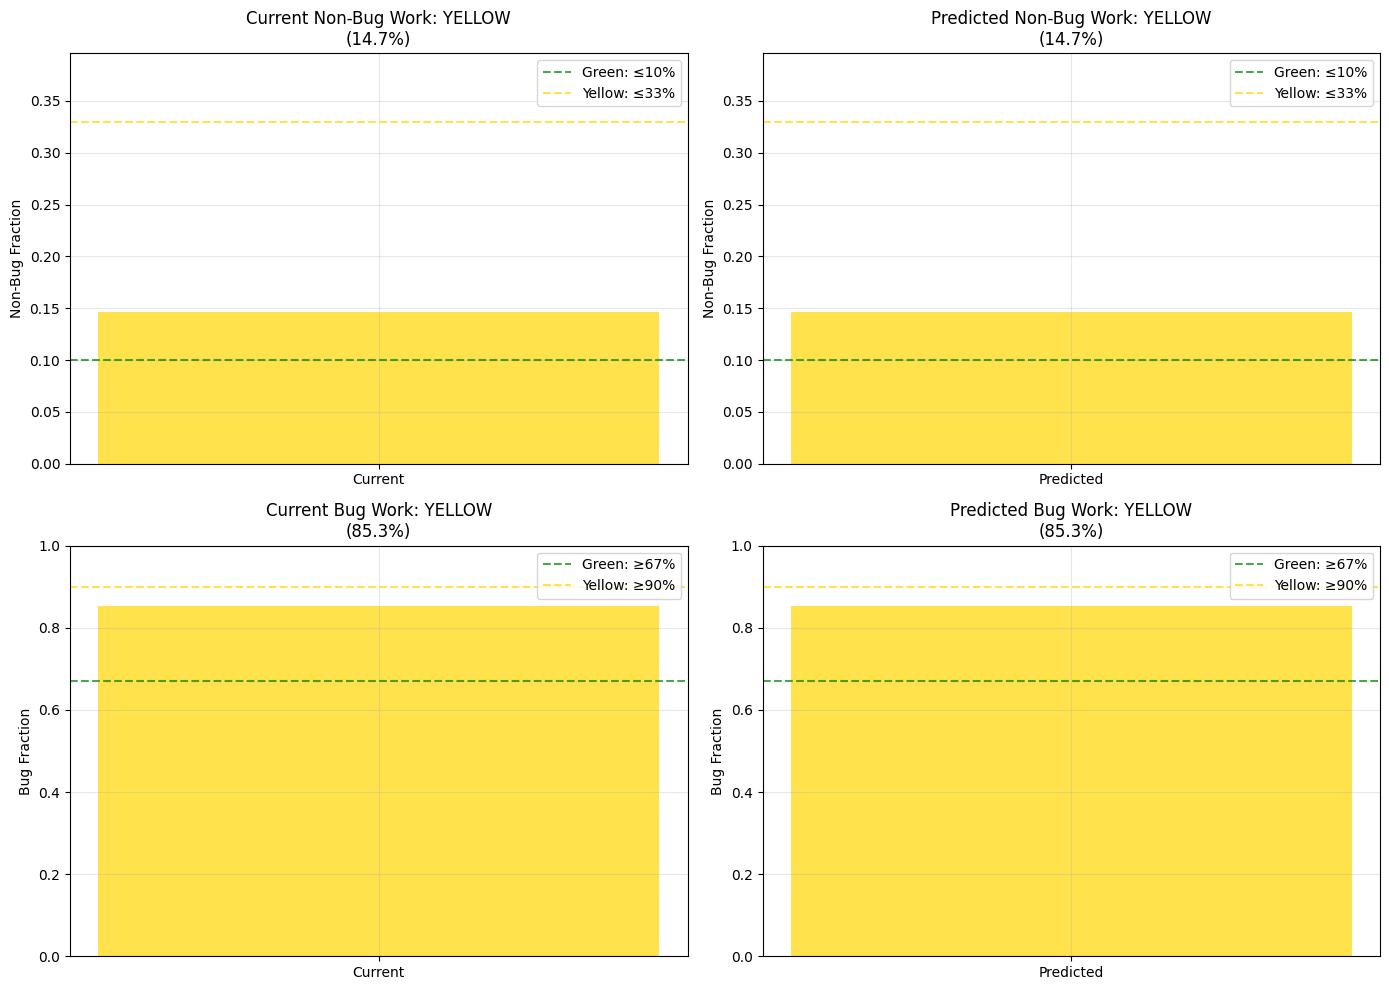

In [78]:
# Visualize traffic light indicators
def plot_traffic_light_indicators():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Define colors
    colors = {'GREEN': 'green', 'YELLOW': 'gold', 'RED': 'red'}
    
    # Calculate bug fractions (complement of non-bug fractions)
    current_bug_fraction = 1 - fraction_unresolved_non_bugs
    predicted_bug_fraction = 1 - predicted_fraction
    
    # Get max value for consistent y-axis scaling
    max_value = max(fraction_unresolved_non_bugs, predicted_fraction, thresholds['yellow']) * 1.2
    
    # Top row: Non-bug fraction perspective
    # Current non-bug indicator
    axes[0,0].bar(['Current'], [fraction_unresolved_non_bugs], 
                  color=colors[current_indicator], alpha=0.7, width=0.5)
    axes[0,0].axhline(y=thresholds['green'], color='green', linestyle='--', alpha=0.7, 
                     label=f'Green: ≤{thresholds["green"]*100:.0f}%')
    axes[0,0].axhline(y=thresholds['yellow'], color='gold', linestyle='--', alpha=0.7, 
                     label=f'Yellow: ≤{thresholds["yellow"]*100:.0f}%')
    axes[0,0].set_ylabel('Non-Bug Fraction')
    axes[0,0].set_title(f'Current Non-Bug Work: {current_indicator}\n({fraction_unresolved_non_bugs*100:.1f}%)')
    axes[0,0].set_ylim(0, max_value)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Predicted non-bug indicator  
    axes[0,1].bar(['Predicted'], [predicted_fraction], 
                  color=colors[predicted_indicator], alpha=0.7, width=0.5)
    axes[0,1].axhline(y=thresholds['green'], color='green', linestyle='--', alpha=0.7, 
                     label=f'Green: ≤{thresholds["green"]*100:.0f}%')
    axes[0,1].axhline(y=thresholds['yellow'], color='gold', linestyle='--', alpha=0.7, 
                     label=f'Yellow: ≤{thresholds["yellow"]*100:.0f}%')
    axes[0,1].set_ylabel('Non-Bug Fraction')
    axes[0,1].set_title(f'Predicted Non-Bug Work: {predicted_indicator}\n({predicted_fraction*100:.1f}%)')
    axes[0,1].set_ylim(0, max_value)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Bottom row: Bug fraction perspective (inverted view)
    bug_max_value = 1.0
    
    # Current bug indicator (inverted colors since we want high bug work = good)
    axes[1,0].bar(['Current'], [current_bug_fraction], 
                  color=colors[current_indicator], alpha=0.7, width=0.5)
    axes[1,0].axhline(y=1-thresholds['yellow'], color='green', linestyle='--', alpha=0.7, 
                     label=f'Green: ≥{(1-thresholds["yellow"])*100:.0f}%')
    axes[1,0].axhline(y=1-thresholds['green'], color='gold', linestyle='--', alpha=0.7, 
                     label=f'Yellow: ≥{(1-thresholds["green"])*100:.0f}%')
    axes[1,0].set_ylabel('Bug Fraction')
    axes[1,0].set_title(f'Current Bug Work: {current_indicator}\n({current_bug_fraction*100:.1f}%)')
    axes[1,0].set_ylim(0, bug_max_value)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Predicted bug indicator
    axes[1,1].bar(['Predicted'], [predicted_bug_fraction], 
                  color=colors[predicted_indicator], alpha=0.7, width=0.5)
    axes[1,1].axhline(y=1-thresholds['yellow'], color='green', linestyle='--', alpha=0.7, 
                     label=f'Green: ≥{(1-thresholds["yellow"])*100:.0f}%')
    axes[1,1].axhline(y=1-thresholds['green'], color='gold', linestyle='--', alpha=0.7, 
                     label=f'Yellow: ≥{(1-thresholds["green"])*100:.0f}%')
    axes[1,1].set_ylabel('Bug Fraction')
    axes[1,1].set_title(f'Predicted Bug Work: {predicted_indicator}\n({predicted_bug_fraction*100:.1f}%)')
    axes[1,1].set_ylim(0, bug_max_value)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_traffic_light_indicators()

## Part II
Looking in to github project `github.com/COVESA/vsomeip` to check:
- Lead Time for Merge Requests (MRs) — time between MR creation and merge

In [89]:
# Get GitHub PR configuration from YAML
github_config = config.get("github_pr_analysis")
repo = github_config["repository"]
per_page = github_config["per_page"]

# Fetch closed pull requests from GitHub API
url = f"https://api.github.com/repos/{repo}/pulls?state=closed&per_page={per_page}"
headers = {"Accept": "application/vnd.github+json"}

print(f"Fetching pull request data from {repo}...")
prs = requests.get(url, headers=headers).json()

# Save raw PR data to CSV (similar to Part I raw data saving)
raw_pr_filename = f"raw_pr_data_{repo.replace('/', '_')}.csv"
print(f"Saving raw PR data to {raw_pr_filename}...")

# Convert raw API response to DataFrame for easier CSV export
import json
raw_pr_data = []
for pr in prs:
    # Flatten the nested structure for CSV export
    raw_pr_record = {
        'pr_number': pr.get('number'),
        'title': pr.get('title', ''),
        'state': pr.get('state'),
        'created_at': pr.get('created_at'),
        'updated_at': pr.get('updated_at'),
        'closed_at': pr.get('closed_at'),
        'merged_at': pr.get('merged_at'),
        'author_login': pr.get('user', {}).get('login', '') if pr.get('user') else '',
        'author_id': pr.get('user', {}).get('id', '') if pr.get('user') else '',
        'merge_commit_sha': pr.get('merge_commit_sha'),
        'changed_files': pr.get('changed_files'),
        'additions': pr.get('additions'),
        'deletions': pr.get('deletions'),
        'comments': pr.get('comments'),
        'review_comments': pr.get('review_comments'),
        'commits': pr.get('commits'),
        'body': pr.get('body', ''),
        'labels': ', '.join([label.get('name', '') for label in pr.get('labels', [])]),
        'assignees': ', '.join([assignee.get('login', '') for assignee in pr.get('assignees', [])]),
        'milestone': pr.get('milestone', {}).get('title', '') if pr.get('milestone') else '',
        'head_ref': pr.get('head', {}).get('ref', '') if pr.get('head') else '',
        'base_ref': pr.get('base', {}).get('ref', '') if pr.get('base') else '',
        'mergeable': pr.get('mergeable'),
        'mergeable_state': pr.get('mergeable_state'),
        'draft': pr.get('draft', False)
    }
    raw_pr_data.append(raw_pr_record)

# Save raw data to CSV
RAW_PR_DATA = pd.DataFrame(raw_pr_data)
RAW_PR_DATA.to_csv(raw_pr_filename, index=False)
print(f"Raw PR data saved to {raw_pr_filename} ({len(RAW_PR_DATA)} PRs)")

# Process PR data to calculate lead times (only for merged PRs)
pr_data = []
for pr in prs:
    if pr.get("merged_at"):
        created = datetime.fromisoformat(pr["created_at"].replace("Z", "+00:00"))
        merged = datetime.fromisoformat(pr["merged_at"].replace("Z", "+00:00"))
        lead_time_days = (merged - created).days
        pr_data.append({
            "id": pr["number"],
            "title": pr["title"],
            "author": pr["user"]["login"],
            "created_at": created,
            "merged_at": merged,
            "lead_time_days": lead_time_days,
            "changed_files": pr.get("changed_files", 0),
            "additions": pr.get("additions", 0),
            "deletions": pr.get("deletions", 0)
        })

print(f"Found {len(pr_data)} merged pull requests")
print(f"Sample data (first 5 PRs):")
for i, pr in enumerate(pr_data[:5]):
    print(f"  PR #{pr['id']}: {pr['lead_time_days']} days - {pr['title'][:50]}...")

# Convert to DataFrame for easier analysis
PR_DATA = pd.DataFrame(pr_data)
print(f"\nPR lead time statistics:")
print(f"  Mean: {PR_DATA['lead_time_days'].mean():.1f} days")
print(f"  Median: {PR_DATA['lead_time_days'].median():.1f} days")
print(f"  Min: {PR_DATA['lead_time_days'].min()} days")
print(f"  Max: {PR_DATA['lead_time_days'].max()} days")
print(f"  Std: {PR_DATA['lead_time_days'].std():.1f} days")

Fetching pull request data from COVESA/vsomeip...
Saving raw PR data to raw_pr_data_COVESA_vsomeip.csv...
Raw PR data saved to raw_pr_data_COVESA_vsomeip.csv (100 PRs)
Found 61 merged pull requests
Sample data (first 5 PRs):
  PR #956: 26 days - vSomeIP 3.5.8 Release...
  PR #955: 0 days - 3.5.8 commits...
  PR #943: 0 days - vSomeip-Lib 3.5.7...
  PR #941: 0 days - 3.5.7 batch2...
  PR #940: 4 days - fix github actions...

PR lead time statistics:
  Mean: 55.8 days
  Median: 4.0 days
  Min: 0 days
  Max: 383 days
  Std: 92.2 days
Saving raw PR data to raw_pr_data_COVESA_vsomeip.csv...
Raw PR data saved to raw_pr_data_COVESA_vsomeip.csv (100 PRs)
Found 61 merged pull requests
Sample data (first 5 PRs):
  PR #956: 26 days - vSomeIP 3.5.8 Release...
  PR #955: 0 days - 3.5.8 commits...
  PR #943: 0 days - vSomeip-Lib 3.5.7...
  PR #941: 0 days - 3.5.7 batch2...
  PR #940: 4 days - fix github actions...

PR lead time statistics:
  Mean: 55.8 days
  Median: 4.0 days
  Min: 0 days
  Max: 38

### Base Measures
Basic metrics for PR lead time analysis.

In [90]:
# Base measures for PR lead time analysis
base_measure_total_prs = len(prs)
print(f"Total number of PRs fetched: {base_measure_total_prs}")

base_measure_merged_prs = len(pr_data)
print(f"Total number of merged PRs: {base_measure_merged_prs}")

base_measure_fast_prs = len([pr for pr in pr_data if pr['lead_time_days'] <= lead_time_thresholds['green']])
print(f"Total number of fast PRs (≤{lead_time_thresholds['green']} days): {base_measure_fast_prs}")

base_measure_slow_prs = len([pr for pr in pr_data if pr['lead_time_days'] > lead_time_thresholds['yellow']])
print(f"Total number of slow PRs (>{lead_time_thresholds['yellow']} days): {base_measure_slow_prs}")

# Save base measures to CSV files
print(f"\nSaving base measures to CSV files...")

# Save all merged PRs data
base_measures_file = f"base_measure_prs_{repo.replace('/', '_')}.csv"
PR_DATA.to_csv(base_measures_file, index=False)
print(f"All merged PRs data saved to {base_measures_file}")

# Save fast PRs (GREEN indicator)
fast_prs_df = PR_DATA[PR_DATA['lead_time_days'] <= lead_time_thresholds['green']]
fast_prs_file = f"base_measure_fast_prs_{repo.replace('/', '_')}.csv"
fast_prs_df.to_csv(fast_prs_file, index=False)
print(f"Fast PRs data saved to {fast_prs_file}")

# Save slow PRs (RED indicator)
slow_prs_df = PR_DATA[PR_DATA['lead_time_days'] > lead_time_thresholds['yellow']]
slow_prs_file = f"base_measure_slow_prs_{repo.replace('/', '_')}.csv"
slow_prs_df.to_csv(slow_prs_file, index=False)
print(f"Slow PRs data saved to {slow_prs_file}")

Total number of PRs fetched: 100
Total number of merged PRs: 61
Total number of fast PRs (≤4 days): 31
Total number of slow PRs (>30 days): 22

Saving base measures to CSV files...
All merged PRs data saved to base_measure_prs_COVESA_vsomeip.csv
Fast PRs data saved to base_measure_fast_prs_COVESA_vsomeip.csv
Slow PRs data saved to base_measure_slow_prs_COVESA_vsomeip.csv


In [91]:
# Function to generate daily PR metrics (similar to new/resolved issues per day in Part I)
def get_prs_created_per_day(pr_df):
    """Calculate number of PRs created per day"""
    if len(pr_df) == 0:
        return pd.DataFrame(columns=['date', 'prs_created'])
    
    # Create a date range from the earliest to latest creation date
    start_date = pr_df['created_at'].min().date()
    end_date = pr_df['created_at'].max().date()
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # Count PRs created each day
    daily_counts = []
    for single_date in date_range:
        count = pr_df[pr_df['created_at'].dt.date == single_date.date()].shape[0]
        daily_counts.append({'date': single_date.date(), 'prs_created': count})
    
    return pd.DataFrame(daily_counts)

def get_prs_merged_per_day(pr_df):
    """Calculate number of PRs merged per day"""
    if len(pr_df) == 0:
        return pd.DataFrame(columns=['date', 'prs_merged'])
    
    # Create a date range from the earliest to latest merge date
    start_date = pr_df['merged_at'].min().date()
    end_date = pr_df['merged_at'].max().date()
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # Count PRs merged each day
    daily_counts = []
    for single_date in date_range:
        count = pr_df[pr_df['merged_at'].dt.date == single_date.date()].shape[0]
        daily_counts.append({'date': single_date.date(), 'prs_merged': count})
    
    return pd.DataFrame(daily_counts)

# Generate daily metrics
PRS_CREATED_DF = get_prs_created_per_day(PR_DATA)
PRS_MERGED_DF = get_prs_merged_per_day(PR_DATA)

# Save daily metrics
prs_created_file = f"prs_created_per_day_{repo.replace('/', '_')}.csv"
PRS_CREATED_DF.to_csv(prs_created_file, index=False)
print(f"PRs created per day data saved to {prs_created_file}")

prs_merged_file = f"prs_merged_per_day_{repo.replace('/', '_')}.csv"
PRS_MERGED_DF.to_csv(prs_merged_file, index=False)
print(f"PRs merged per day data saved to {prs_merged_file}")

PRs created per day data saved to prs_created_per_day_COVESA_vsomeip.csv
PRs merged per day data saved to prs_merged_per_day_COVESA_vsomeip.csv


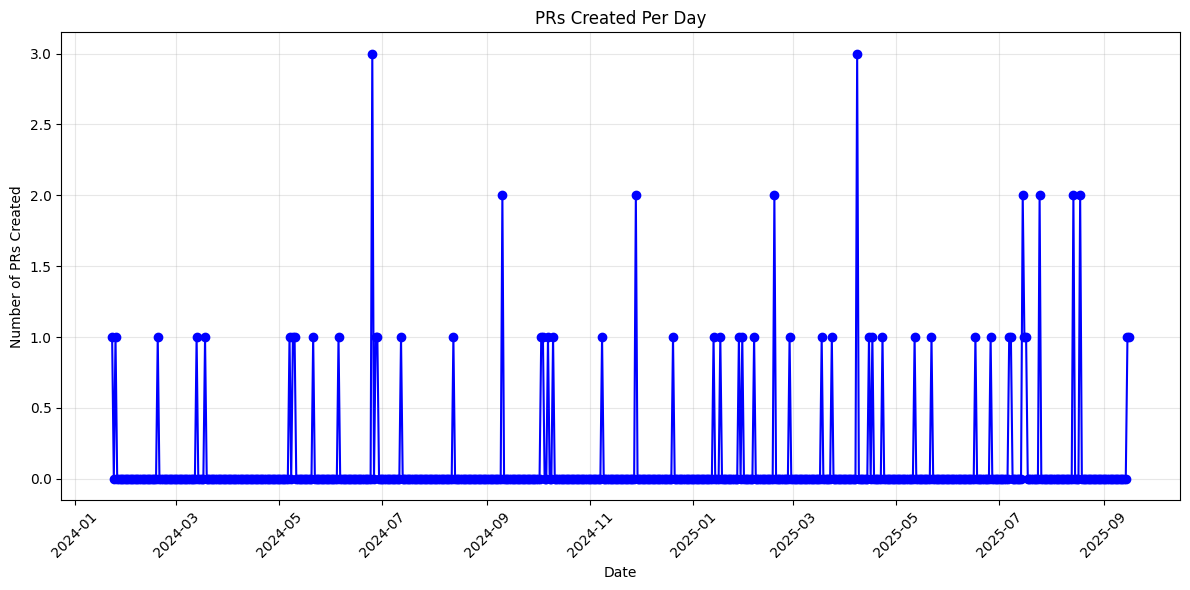

In [92]:
# Visualize PRs created per day
plt.figure(figsize=(12, 6))
plt.plot(PRS_CREATED_DF['date'], PRS_CREATED_DF['prs_created'], marker='o', linestyle='-', color='blue')
plt.title('PRs Created Per Day')
plt.xlabel('Date')
plt.ylabel('Number of PRs Created')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

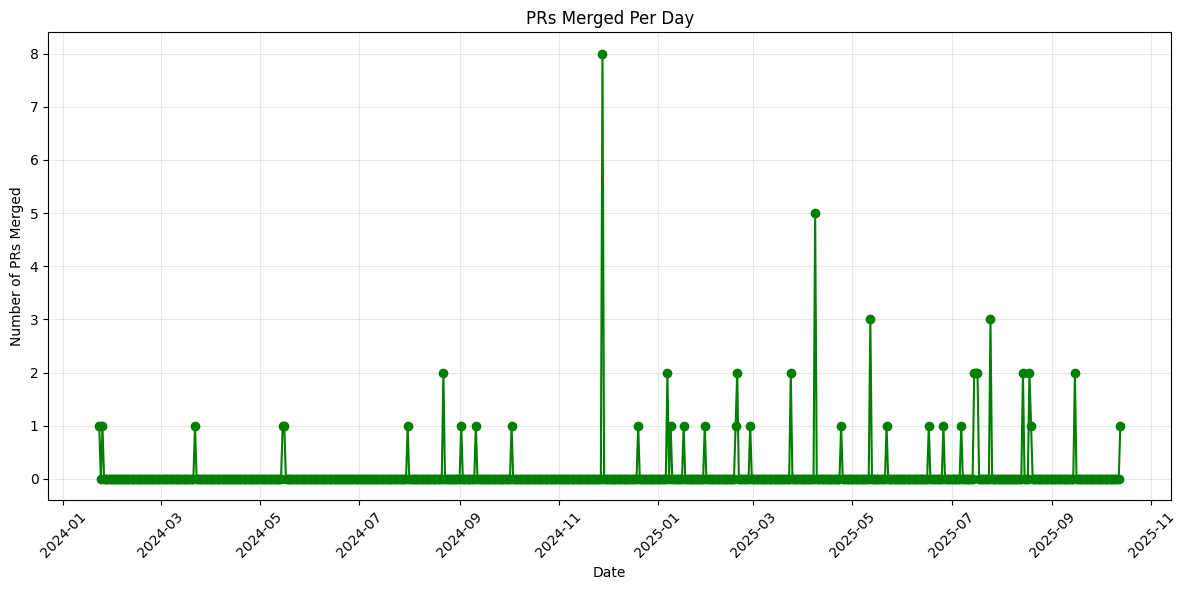

In [93]:
# Visualize PRs merged per day
plt.figure(figsize=(12, 6))
plt.plot(PRS_MERGED_DF['date'], PRS_MERGED_DF['prs_merged'], marker='o', linestyle='-', color='green')
plt.title('PRs Merged Per Day')
plt.xlabel('Date')
plt.ylabel('Number of PRs Merged')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Lead time distribution data saved to lead_time_distribution_COVESA_vsomeip.csv


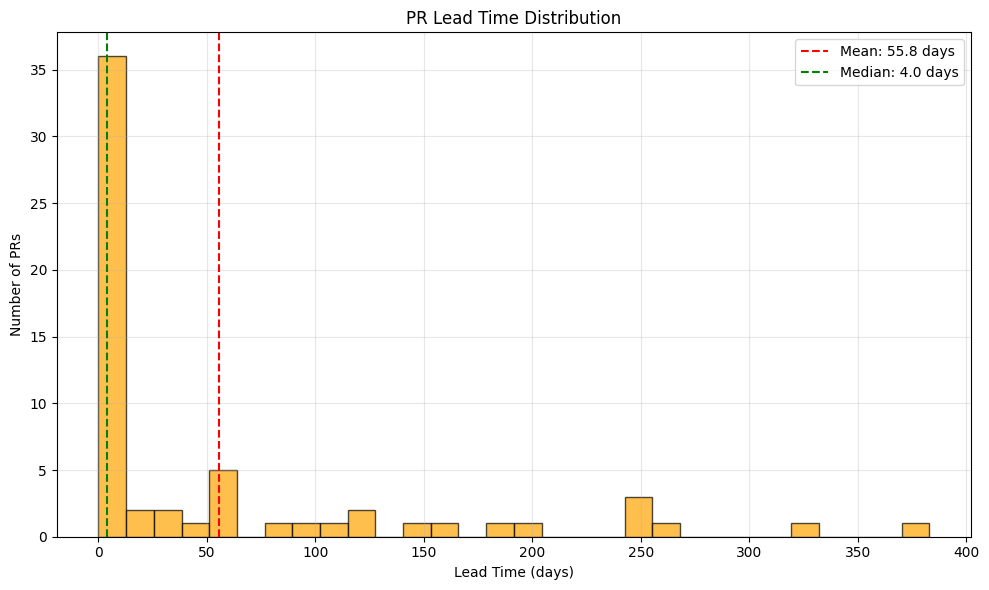

In [94]:
# Create lead time distribution data and save to CSV
lead_time_distribution_df = PR_DATA[['id', 'title', 'author', 'created_at', 'merged_at', 'lead_time_days']].copy()
lead_time_file = f"lead_time_distribution_{repo.replace('/', '_')}.csv"
lead_time_distribution_df.to_csv(lead_time_file, index=False)
print(f"Lead time distribution data saved to {lead_time_file}")

# Visualize lead time distribution
def plot_lead_time_distribution(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['lead_time_days'], bins=30, color='orange', alpha=0.7, edgecolor='black')
    plt.axvline(df['lead_time_days'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["lead_time_days"].mean():.1f} days')
    plt.axvline(df['lead_time_days'].median(), color='green', linestyle='--', 
                label=f'Median: {df["lead_time_days"].median():.1f} days')
    plt.title('PR Lead Time Distribution')
    plt.xlabel('Lead Time (days)')
    plt.ylabel('Number of PRs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_lead_time_distribution(PR_DATA)

### Derived Measures
Advanced metrics and predictions for PR lead time analysis.

In [95]:
# Calculate derived measures for PR lead times
def calculate_average_lead_time(df):
    """Calculate average lead time"""
    return df['lead_time_days'].mean()

def calculate_lead_time_percentiles(df):
    """Calculate lead time percentiles"""
    return {
        'p50': df['lead_time_days'].quantile(0.50),
        'p75': df['lead_time_days'].quantile(0.75),
        'p90': df['lead_time_days'].quantile(0.90),
        'p95': df['lead_time_days'].quantile(0.95)
    }

# Calculate derived measures
average_lead_time = calculate_average_lead_time(PR_DATA)
lead_time_percentiles = calculate_lead_time_percentiles(PR_DATA)

print(f"=== DERIVED MEASURES ===")
print(f"Average lead time: {average_lead_time:.1f} days")
print(f"Median lead time (P50): {lead_time_percentiles['p50']:.1f} days")
print(f"75th percentile (P75): {lead_time_percentiles['p75']:.1f} days")
print(f"90th percentile (P90): {lead_time_percentiles['p90']:.1f} days")
print(f"95th percentile (P95): {lead_time_percentiles['p95']:.1f} days")

# Calculate efficiency metrics
fast_pr_rate = (base_measure_fast_prs / base_measure_merged_prs) * 100
slow_pr_rate = (base_measure_slow_prs / base_measure_merged_prs) * 100

print(f"\n=== EFFICIENCY METRICS ===")
print(f"Fast PR rate: {fast_pr_rate:.1f}% (≤{lead_time_thresholds['green']} days)")
print(f"Slow PR rate: {slow_pr_rate:.1f}% (>{lead_time_thresholds['yellow']} days)")

# Save derived measures to CSV
derived_measures = {
    'metric': ['average_lead_time', 'median_lead_time', 'p75_lead_time', 'p90_lead_time', 'p95_lead_time', 'fast_pr_rate', 'slow_pr_rate'],
    'value': [average_lead_time, lead_time_percentiles['p50'], lead_time_percentiles['p75'], 
              lead_time_percentiles['p90'], lead_time_percentiles['p95'], fast_pr_rate, slow_pr_rate],
    'unit': ['days', 'days', 'days', 'days', 'days', 'percent', 'percent']
}

derived_measures_df = pd.DataFrame(derived_measures)
derived_measures_file = f"derived_measures_prs_{repo.replace('/', '_')}.csv"
derived_measures_df.to_csv(derived_measures_file, index=False)
print(f"\nDerived measures saved to {derived_measures_file}")

=== DERIVED MEASURES ===
Average lead time: 55.8 days
Median lead time (P50): 4.0 days
75th percentile (P75): 61.0 days
90th percentile (P90): 198.0 days
95th percentile (P95): 255.0 days

=== EFFICIENCY METRICS ===
Fast PR rate: 50.8% (≤4 days)
Slow PR rate: 36.1% (>30 days)

Derived measures saved to derived_measures_prs_COVESA_vsomeip.csv


In [ ]:
# PR Complexity Analysis based on number of files changed
def classify_pr_complexity(changed_files):
    """
    Classify PR complexity based on number of files changed using config thresholds
    Simple: 1-3 files (configurable)
    Medium: 4-10 files (configurable)
    Complex: 11-25 files (configurable)
    Very Complex: >25 files (configurable)
    """
    complexity_config = config.get('pr_complexity', {
        'simple': 3, 'medium': 10, 'complex': 25
    })
    
    if changed_files <= complexity_config['simple']:
        return 'Simple'
    elif changed_files <= complexity_config['medium']:
        return 'Medium'
    elif changed_files <= complexity_config['complex']:
        return 'Complex'
    else:
        return 'Very Complex'

# Add complexity classification to PR data
PR_DATA['complexity'] = PR_DATA['changed_files'].apply(classify_pr_complexity)

print("=== PR COMPLEXITY ANALYSIS ===")
print(f"Complexity thresholds from config:")
complexity_config = config.get('pr_complexity', {'simple': 3, 'medium': 10, 'complex': 25})
print(f"  Simple: ≤{complexity_config['simple']} files")
print(f"  Medium: {complexity_config['simple']+1}-{complexity_config['medium']} files")
print(f"  Complex: {complexity_config['medium']+1}-{complexity_config['complex']} files")
print(f"  Very Complex: >{complexity_config['complex']} files")

complexity_counts = PR_DATA['complexity'].value_counts()
print(f"\nPR Distribution by Complexity:")
for complexity in ['Simple', 'Medium', 'Complex', 'Very Complex']:
    count = complexity_counts.get(complexity, 0)
    percentage = (count / len(PR_DATA)) * 100
    print(f"  {complexity}: {count}/{len(PR_DATA)} PRs ({percentage:.1f}%)")

# Analyze lead time by complexity
complexity_stats = PR_DATA.groupby('complexity')['lead_time_days'].agg(['count', 'mean', 'median', 'std']).round(2)
print(f"\nLead Time Statistics by Complexity:")
print(complexity_stats)

# Calculate correlation between complexity and lead time
files_correlation = PR_DATA['changed_files'].corr(PR_DATA['lead_time_days'])
print(f"\nCorrelation between files changed and lead time: {files_correlation:.3f}")

# Complexity distribution analysis
print(f"\n=== FILES CHANGED STATISTICS ===")
print(f"Mean files changed: {PR_DATA['changed_files'].mean():.1f}")
print(f"Median files changed: {PR_DATA['changed_files'].median():.1f}")
print(f"Min files changed: {PR_DATA['changed_files'].min()}")
print(f"Max files changed: {PR_DATA['changed_files'].max()}")
print(f"95th percentile files changed: {PR_DATA['changed_files'].quantile(0.95):.1f}")

# Save complexity analysis to CSV
complexity_analysis = {
    'complexity': ['Simple', 'Medium', 'Complex', 'Very Complex'],
    'pr_count': [complexity_counts.get(c, 0) for c in ['Simple', 'Medium', 'Complex', 'Very Complex']],
    'percentage': [(complexity_counts.get(c, 0) / len(PR_DATA)) * 100 for c in ['Simple', 'Medium', 'Complex', 'Very Complex']],
    'avg_lead_time': [complexity_stats.loc[c, 'mean'] if c in complexity_stats.index else 0 for c in ['Simple', 'Medium', 'Complex', 'Very Complex']],
    'median_lead_time': [complexity_stats.loc[c, 'median'] if c in complexity_stats.index else 0 for c in ['Simple', 'Medium', 'Complex', 'Very Complex']]
}

complexity_df = pd.DataFrame(complexity_analysis)
complexity_file = f"pr_complexity_analysis_{repo.replace('/', '_')}.csv"
complexity_df.to_csv(complexity_file, index=False)
print(f"\nComplexity analysis saved to {complexity_file}")

# Save detailed PR data with complexity
pr_with_complexity_file = f"prs_with_complexity_{repo.replace('/', '_')}.csv"
PR_DATA.to_csv(pr_with_complexity_file, index=False)
print(f"PRs with complexity classification saved to {pr_with_complexity_file}")

In [ ]:
# Visualize PR complexity analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Subplot 1: PR distribution by complexity
complexity_labels = ['Simple', 'Medium', 'Complex', 'Very Complex']
complexity_values = [complexity_counts.get(label, 0) for label in complexity_labels]
complexity_colors = ['green', 'yellow', 'orange', 'red']

bars1 = axes[0,0].bar(complexity_labels, complexity_values, color=complexity_colors, alpha=0.7)
axes[0,0].set_ylabel('Number of PRs')
axes[0,0].set_title('PR Distribution by Complexity\n(Based on Files Changed)')
axes[0,0].grid(True, alpha=0.3)

# Add percentage labels on bars
for bar, value in zip(bars1, complexity_values):
    height = bar.get_height()
    percentage = (value / len(PR_DATA)) * 100
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                  f'{value}\n({percentage:.1f}%)', ha='center', va='bottom')

# Subplot 2: Average lead time by complexity
avg_lead_times = [complexity_stats.loc[c, 'mean'] if c in complexity_stats.index else 0 for c in complexity_labels]
bars2 = axes[0,1].bar(complexity_labels, avg_lead_times, color=complexity_colors, alpha=0.7)
axes[0,1].set_ylabel('Average Lead Time (days)')
axes[0,1].set_title('Average Lead Time by Complexity')
axes[0,1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars2, avg_lead_times):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                  f'{value:.1f}d', ha='center', va='bottom')

# Subplot 3: Scatter plot - Files changed vs Lead time
scatter = axes[1,0].scatter(PR_DATA['changed_files'], PR_DATA['lead_time_days'], 
                           c=[complexity_colors[complexity_labels.index(c)] for c in PR_DATA['complexity']], 
                           alpha=0.6, s=50)
axes[1,0].set_xlabel('Files Changed')
axes[1,0].set_ylabel('Lead Time (days)')
axes[1,0].set_title(f'Lead Time vs Files Changed\n(Correlation: {files_correlation:.3f})')
axes[1,0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(PR_DATA['changed_files'], PR_DATA['lead_time_days'], 1)
p = np.poly1d(z)
axes[1,0].plot(PR_DATA['changed_files'], p(PR_DATA['changed_files']), "r--", alpha=0.8)

# Subplot 4: Box plot of lead times by complexity
complexity_data = [PR_DATA[PR_DATA['complexity'] == c]['lead_time_days'].values 
                  for c in complexity_labels if c in PR_DATA['complexity'].values]
box_plot = axes[1,1].boxplot(complexity_data, labels=[c for c in complexity_labels if c in PR_DATA['complexity'].values],
                            patch_artist=True)

# Color the box plots
for patch, color in zip(box_plot['boxes'], complexity_colors[:len(box_plot['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1,1].set_ylabel('Lead Time (days)')
axes[1,1].set_title('Lead Time Distribution by Complexity')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print(f"\n=== COMPLEXITY INSIGHTS ===")
if files_correlation > 0.3:
    print(f"✅ Strong positive correlation ({files_correlation:.3f}) between files changed and lead time")
    print("   → More complex PRs (more files) take longer to review and merge")
elif files_correlation > 0.1:
    print(f"⚠️  Moderate correlation ({files_correlation:.3f}) between files changed and lead time")
    print("   → Some relationship between complexity and lead time")
else:
    print(f"ℹ️  Weak correlation ({files_correlation:.3f}) between files changed and lead time")
    print("   → Lead time may be influenced by other factors beyond file count")

# Find the most efficient complexity level
if len(complexity_stats) > 0:
    best_complexity = complexity_stats['mean'].idxmin()
    worst_complexity = complexity_stats['mean'].idxmax()
    print(f"\nFastest turnaround: {best_complexity} PRs ({complexity_stats.loc[best_complexity, 'mean']:.1f} days average)")
    print(f"Slowest turnaround: {worst_complexity} PRs ({complexity_stats.loc[worst_complexity, 'mean']:.1f} days average)")

# Recommendations
simple_prs = complexity_counts.get('Simple', 0)
complex_prs = complexity_counts.get('Complex', 0) + complexity_counts.get('Very Complex', 0)
total_prs = len(PR_DATA)

print(f"\n=== RECOMMENDATIONS ===")
if simple_prs / total_prs > 0.6:
    print("✅ Good practice: High proportion of simple PRs (≤3 files)")
    print("   → Continue encouraging small, focused changes")
else:
    print("⚠️  Consider breaking down larger PRs into smaller ones")
    print("   → Aim for more simple PRs (≤3 files) for faster review cycles")

if complex_prs / total_prs > 0.2:
    print("⚠️  High proportion of complex PRs (>10 files)")
    print("   → Consider architectural changes to enable smaller PRs")
    print("   → Implement feature flags for incremental delivery")

In [96]:
# Prediction functions for future PR metrics
def predict_future_lead_times(df, num_predictions):
    """Predict future lead times based on historical average"""
    avg = float(calculate_average_lead_time(df))
    return [avg] * num_predictions

def predict_future_pr_creation(df, num_predictions, window_size=7):
    """Predict future PR creation rate using moving average"""
    if len(df) == 0:
        return [0] * num_predictions
    
    # Work on a copy to avoid side effects
    s = pd.to_numeric(df['prs_created'], errors='coerce')
    
    # Strict rolling window; only produce means when the window is complete
    ma = s.rolling(window=window_size, min_periods=window_size).mean()
    
    # If we have at least one full-window mean, use the last one; otherwise fallback to simple mean
    last_ma = ma.dropna().iloc[-1] if ma.notna().any() else s.mean()
    
    val = float(last_ma) if not pd.isna(last_ma) else 0.0
    return [val] * num_predictions

def predict_future_throughput(current_avg_lead_time, predicted_prs_created):
    """Predict future PR throughput based on lead time and creation rate"""
    # Simple model: throughput = creation_rate / (1 + lead_time_factor)  
    lead_time_factor = current_avg_lead_time / 10  # Normalize lead time impact
    throughput = []
    for created in predicted_prs_created:
        daily_throughput = created / (1 + lead_time_factor)
        throughput.append(daily_throughput)
    return throughput

# Generate predictions for next 10 days
num_days = 10
future_lead_time_predictions = predict_future_lead_times(PR_DATA, num_days)
future_pr_creation_predictions = predict_future_pr_creation(PRS_CREATED_DF, num_days)
future_throughput_predictions = predict_future_throughput(average_lead_time, future_pr_creation_predictions)

print(f"=== PREDICTIONS FOR NEXT {num_days} DAYS ===")
print(f"Predicted lead times: {[f'{x:.1f}' for x in future_lead_time_predictions[:5]]}... days")
print(f"Predicted PR creation rate: {[f'{x:.1f}' for x in future_pr_creation_predictions[:5]]}... PRs/day")
print(f"Predicted throughput: {[f'{x:.1f}' for x in future_throughput_predictions[:5]]}... PRs/day")

# Save predictions to CSV
predictions_data = {
    'day': list(range(1, num_days + 1)),
    'predicted_lead_time': future_lead_time_predictions,
    'predicted_pr_creation': future_pr_creation_predictions,
    'predicted_throughput': future_throughput_predictions
}

predictions_df = pd.DataFrame(predictions_data)
predictions_file = f"pr_predictions_{repo.replace('/', '_')}.csv"
predictions_df.to_csv(predictions_file, index=False)
print(f"\nPredictions saved to {predictions_file}")

=== PREDICTIONS FOR NEXT 10 DAYS ===
Predicted lead times: ['55.8', '55.8', '55.8', '55.8', '55.8']... days
Predicted PR creation rate: ['0.3', '0.3', '0.3', '0.3', '0.3']... PRs/day
Predicted throughput: ['0.0', '0.0', '0.0', '0.0', '0.0']... PRs/day

Predictions saved to pr_predictions_COVESA_vsomeip.csv


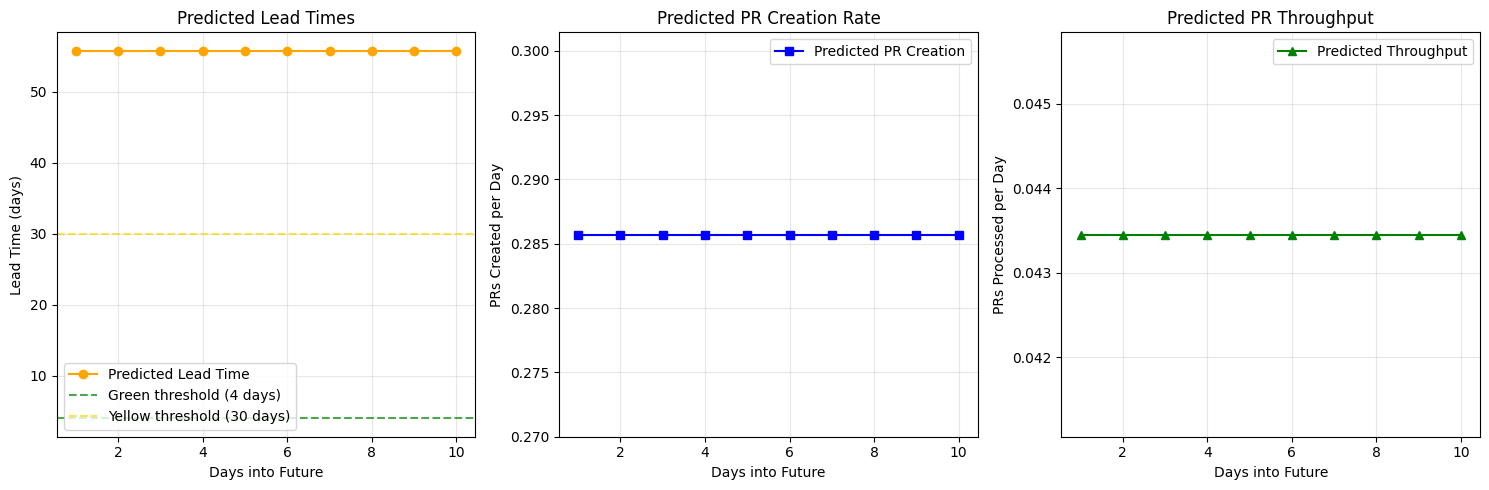


=== SUMMARY OF SAVED FILES ===
Raw Data:
  - raw_pr_data_COVESA_vsomeip.csv
Base Measures:
  - base_measure_prs_COVESA_vsomeip.csv
  - base_measure_fast_prs_COVESA_vsomeip.csv
  - base_measure_slow_prs_COVESA_vsomeip.csv
Daily Metrics:
  - prs_created_per_day_COVESA_vsomeip.csv
  - prs_merged_per_day_COVESA_vsomeip.csv
Distribution Data:
  - lead_time_distribution_COVESA_vsomeip.csv
Derived Measures:
  - derived_measures_prs_COVESA_vsomeip.csv
Predictions:
  - pr_predictions_COVESA_vsomeip.csv


In [ ]:
# Visualize predictions
plt.figure(figsize=(15, 5))

# Subplot 1: Lead time predictions
plt.subplot(1, 3, 1)
plt.plot(range(1, num_days + 1), future_lead_time_predictions, 
         label='Predicted Lead Time', marker='o', color='orange')
plt.axhline(y=lead_time_thresholds['green'], color='green', linestyle='--', alpha=0.7, 
           label=f'Green threshold ({lead_time_thresholds["green"]} days)')
plt.axhline(y=lead_time_thresholds['yellow'], color='gold', linestyle='--', alpha=0.7, 
           label=f'Yellow threshold ({lead_time_thresholds["yellow"]} days)')
plt.title('Predicted Lead Times')
plt.xlabel('Days into Future')
plt.ylabel('Lead Time (days)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: PR creation predictions
plt.subplot(1, 3, 2)
plt.plot(range(1, num_days + 1), future_pr_creation_predictions, 
         label='Predicted PR Creation', marker='s', color='blue')
plt.title('Predicted PR Creation Rate')
plt.xlabel('Days into Future')
plt.ylabel('PRs Created per Day')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Throughput predictions
plt.subplot(1, 3, 3)
plt.plot(range(1, num_days + 1), future_throughput_predictions, 
         label='Predicted Throughput', marker='^', color='green')
plt.title('Predicted PR Throughput')
plt.xlabel('Days into Future')
plt.ylabel('PRs Processed per Day')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of all saved files
print(f"\n=== SUMMARY OF SAVED FILES ===")
print(f"Raw Data:")
print(f"  - {raw_pr_filename}")
print(f"Base Measures:")
print(f"  - {base_measures_file}")
print(f"  - {fast_prs_file}")
print(f"  - {slow_prs_file}")
print(f"Daily Metrics:")
print(f"  - {prs_created_file}")
print(f"  - {prs_merged_file}")
print(f"Distribution Data:")
print(f"  - {lead_time_file}")
print(f"Derived Measures:")
print(f"  - {derived_measures_file}")
print(f"Complexity Analysis:")
print(f"  - {complexity_file}")
print(f"  - {pr_with_complexity_file}")
print(f"Predictions:")
print(f"  - {predictions_file}")

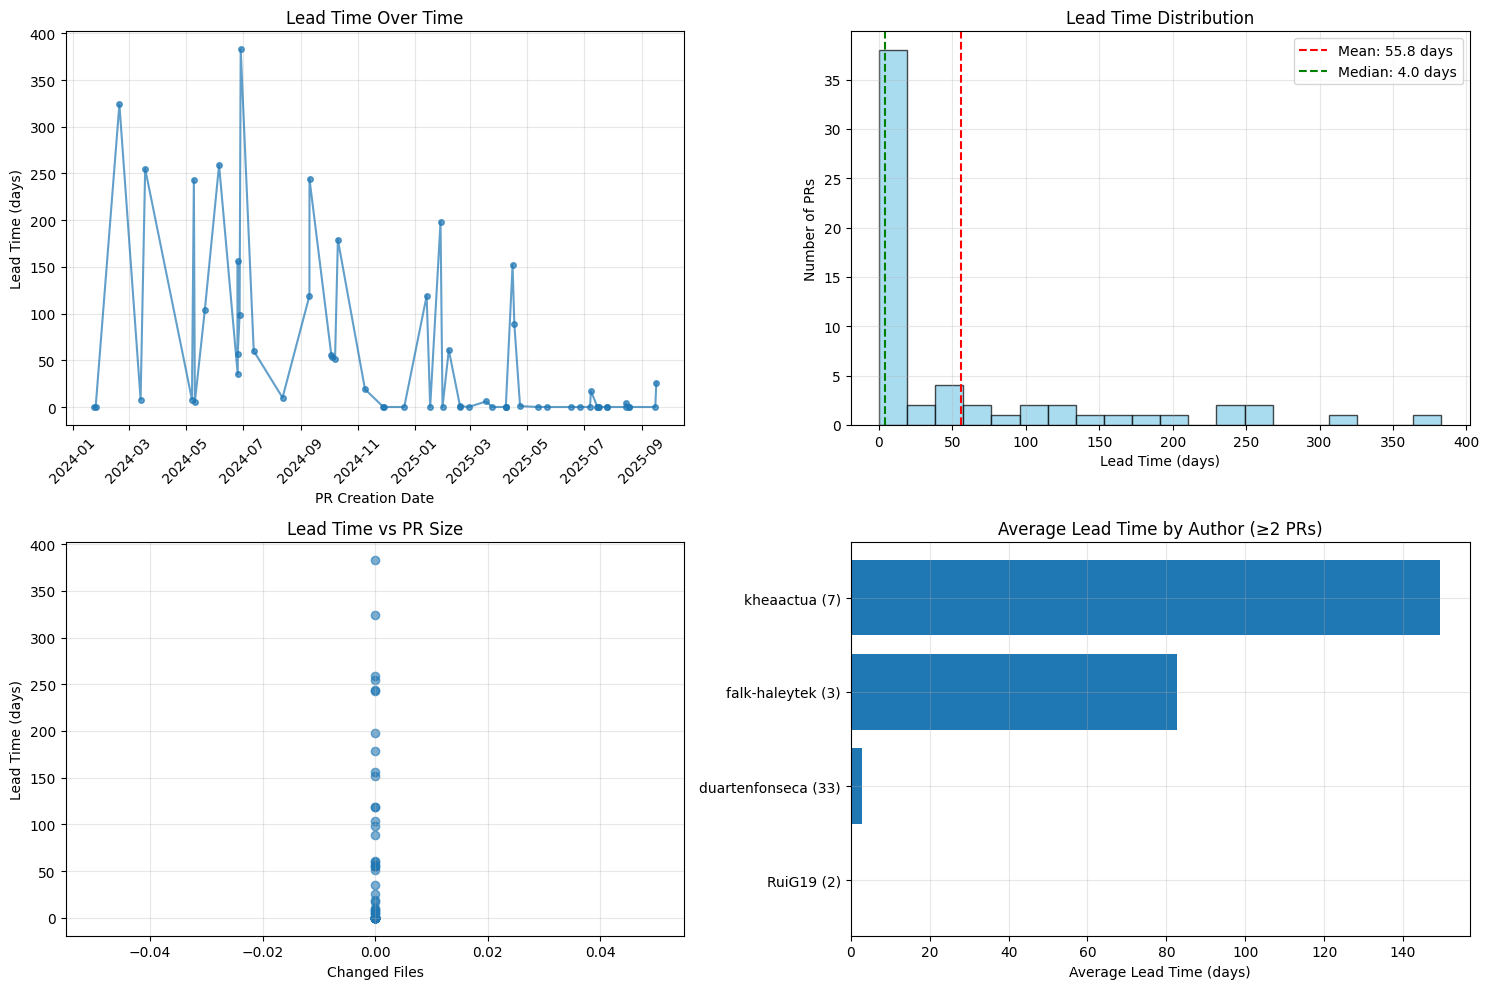

In [98]:
# Enhanced visualization of PR lead times with multiple perspectives
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Lead time over time (by PR creation date)
PR_DATA_sorted = PR_DATA.sort_values('created_at')
axes[0,0].plot(PR_DATA_sorted['created_at'], PR_DATA_sorted['lead_time_days'], 
               marker='o', alpha=0.7, markersize=4)
axes[0,0].set_title('Lead Time Over Time')
axes[0,0].set_xlabel('PR Creation Date')
axes[0,0].set_ylabel('Lead Time (days)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Subplot 2: Lead time distribution
axes[0,1].hist(PR_DATA['lead_time_days'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
axes[0,1].axvline(PR_DATA['lead_time_days'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {PR_DATA["lead_time_days"].mean():.1f} days')
axes[0,1].axvline(PR_DATA['lead_time_days'].median(), color='green', linestyle='--', 
                  label=f'Median: {PR_DATA["lead_time_days"].median():.1f} days')
axes[0,1].set_title('Lead Time Distribution')
axes[0,1].set_xlabel('Lead Time (days)')
axes[0,1].set_ylabel('Number of PRs')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Subplot 3: Lead time vs PR size (changed files)
axes[1,0].scatter(PR_DATA['changed_files'], PR_DATA['lead_time_days'], alpha=0.6)
axes[1,0].set_title('Lead Time vs PR Size')
axes[1,0].set_xlabel('Changed Files')
axes[1,0].set_ylabel('Lead Time (days)')
axes[1,0].grid(True, alpha=0.3)

# Subplot 4: Top authors by average lead time
author_stats = PR_DATA.groupby('author').agg({
    'lead_time_days': ['count', 'mean']
}).round(1)
author_stats.columns = ['pr_count', 'avg_lead_time']
author_stats = author_stats[author_stats['pr_count'] >= 2].sort_values('avg_lead_time').head(10)

bars = axes[1,1].barh(range(len(author_stats)), author_stats['avg_lead_time'])
axes[1,1].set_yticks(range(len(author_stats)))
axes[1,1].set_yticklabels([f"{author} ({count})" for author, count in 
                           zip(author_stats.index, author_stats['pr_count'])])
axes[1,1].set_title('Average Lead Time by Author (≥2 PRs)')
axes[1,1].set_xlabel('Average Lead Time (days)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [99]:
# Traffic light indicators for PR lead times
def lead_time_traffic_light_indicator(value, thresholds):
    """
    Returns traffic light color based on lead time thresholds
    GREEN: Fast turnaround (≤ 4 days - excellent responsiveness)
    YELLOW: Reasonable time (4-30 days - acceptable)
    RED: Too slow (> 30 days - needs attention)
    """
    if value <= thresholds['green']:
        return 'GREEN'
    elif value <= thresholds['yellow']:
        return 'YELLOW'
    else:
        return 'RED'

# Get lead time thresholds from config
lead_time_thresholds = config['indicators']['lead_time_days']

# Calculate current metrics
current_avg_lead_time = PR_DATA['lead_time_days'].mean()
current_median_lead_time = PR_DATA['lead_time_days'].median()

# Calculate indicators
current_avg_indicator = lead_time_traffic_light_indicator(current_avg_lead_time, lead_time_thresholds)
current_median_indicator = lead_time_traffic_light_indicator(current_median_lead_time, lead_time_thresholds)

# Calculate distribution of PRs by indicator
pr_indicators = [lead_time_traffic_light_indicator(lt, lead_time_thresholds) for lt in PR_DATA['lead_time_days']]
indicator_counts = pd.Series(pr_indicators).value_counts()

# Display results
print("=== PR LEAD TIME TRAFFIC LIGHT INDICATORS ===")
print(f"Average lead time: {current_avg_lead_time:.1f} days → {current_avg_indicator}")
print(f"Median lead time: {current_median_lead_time:.1f} days → {current_median_indicator}")

print(f"\nPR Distribution by Indicator:")
for color in ['GREEN', 'YELLOW', 'RED']:
    count = indicator_counts.get(color, 0)
    percentage = (count / len(PR_DATA)) * 100
    print(f"  {color}: {count}/{len(PR_DATA)} PRs ({percentage:.1f}%)")

print(f"\nThresholds:")
print(f"  GREEN: ≤ {lead_time_thresholds['green']} days (fast turnaround)")
print(f"  YELLOW: {lead_time_thresholds['green']+1}-{lead_time_thresholds['yellow']} days (reasonable)")
print(f"  RED: > {lead_time_thresholds['yellow']} days (too slow)")

# Simple prediction: assume current trend continues
predicted_avg_lead_time = current_avg_lead_time  # Simple constant prediction
predicted_indicator = lead_time_traffic_light_indicator(predicted_avg_lead_time, lead_time_thresholds)
print(f"\nPredicted average lead time: {predicted_avg_lead_time:.1f} days → {predicted_indicator}")

=== PR LEAD TIME TRAFFIC LIGHT INDICATORS ===
Average lead time: 55.8 days → RED
Median lead time: 4.0 days → GREEN

PR Distribution by Indicator:
  GREEN: 31/61 PRs (50.8%)
  YELLOW: 8/61 PRs (13.1%)
  RED: 22/61 PRs (36.1%)

Thresholds:
  GREEN: ≤ 4 days (fast turnaround)
  YELLOW: 5-30 days (reasonable)
  RED: > 30 days (too slow)

Predicted average lead time: 55.8 days → RED


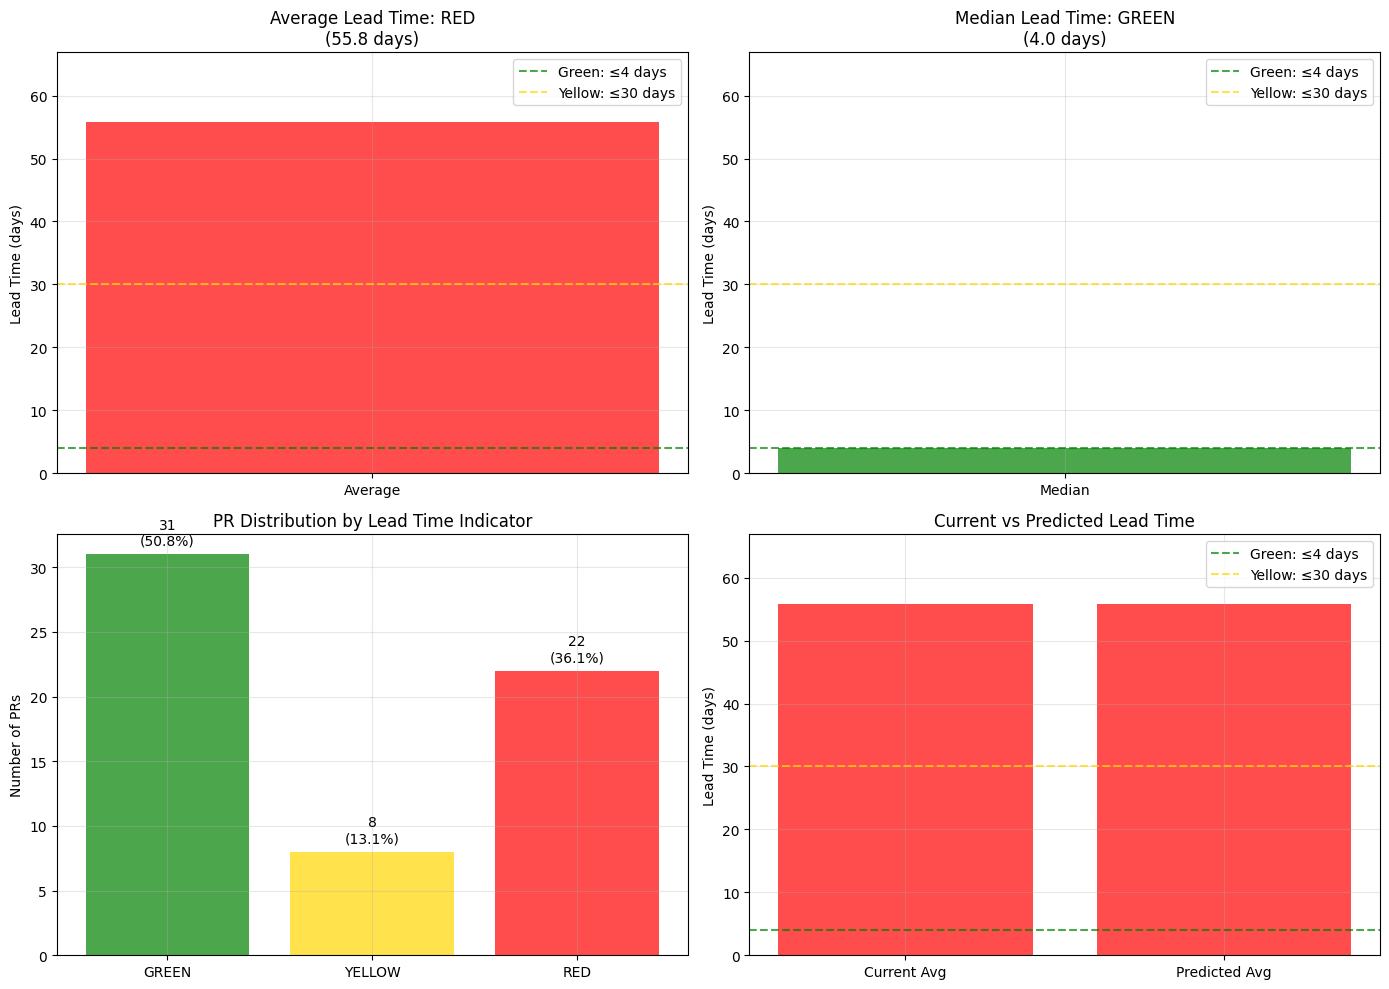

In [100]:
# Visualize PR lead time traffic light indicators
def plot_lead_time_traffic_light_indicators():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Define colors
    colors = {'GREEN': 'green', 'YELLOW': 'gold', 'RED': 'red'}
    
    # Calculate metrics
    max_lead_time = max(current_avg_lead_time, current_median_lead_time, lead_time_thresholds['yellow']) * 1.2
    
    # Top left: Current average lead time indicator
    axes[0,0].bar(['Average'], [current_avg_lead_time], 
                  color=colors[current_avg_indicator], alpha=0.7, width=0.5)
    axes[0,0].axhline(y=lead_time_thresholds['green'], color='green', linestyle='--', alpha=0.7, 
                     label=f'Green: ≤{lead_time_thresholds["green"]} days')
    axes[0,0].axhline(y=lead_time_thresholds['yellow'], color='gold', linestyle='--', alpha=0.7, 
                     label=f'Yellow: ≤{lead_time_thresholds["yellow"]} days')
    axes[0,0].set_ylabel('Lead Time (days)')
    axes[0,0].set_title(f'Average Lead Time: {current_avg_indicator}\n({current_avg_lead_time:.1f} days)')
    axes[0,0].set_ylim(0, max_lead_time)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Top right: Current median lead time indicator
    axes[0,1].bar(['Median'], [current_median_lead_time], 
                  color=colors[current_median_indicator], alpha=0.7, width=0.5)
    axes[0,1].axhline(y=lead_time_thresholds['green'], color='green', linestyle='--', alpha=0.7, 
                     label=f'Green: ≤{lead_time_thresholds["green"]} days')
    axes[0,1].axhline(y=lead_time_thresholds['yellow'], color='gold', linestyle='--', alpha=0.7, 
                     label=f'Yellow: ≤{lead_time_thresholds["yellow"]} days')
    axes[0,1].set_ylabel('Lead Time (days)')
    axes[0,1].set_title(f'Median Lead Time: {current_median_indicator}\n({current_median_lead_time:.1f} days)')
    axes[0,1].set_ylim(0, max_lead_time)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Bottom left: PR distribution by indicator
    indicator_labels = ['GREEN', 'YELLOW', 'RED']
    indicator_values = [indicator_counts.get(label, 0) for label in indicator_labels]
    indicator_colors = [colors[label] for label in indicator_labels]
    
    bars = axes[1,0].bar(indicator_labels, indicator_values, color=indicator_colors, alpha=0.7)
    axes[1,0].set_ylabel('Number of PRs')
    axes[1,0].set_title('PR Distribution by Lead Time Indicator')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    total_prs = len(PR_DATA)
    for bar, value in zip(bars, indicator_values):
        height = bar.get_height()
        percentage = (value / total_prs) * 100
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{value}\n({percentage:.1f}%)', ha='center', va='bottom')
    
    # Bottom right: Predicted vs current comparison
    metrics = ['Current Avg', 'Predicted Avg']
    values = [current_avg_lead_time, predicted_avg_lead_time]
    indicator_colors_pred = [colors[current_avg_indicator], colors[predicted_indicator]]
    
    axes[1,1].bar(metrics, values, color=indicator_colors_pred, alpha=0.7)
    axes[1,1].axhline(y=lead_time_thresholds['green'], color='green', linestyle='--', alpha=0.7, 
                     label=f'Green: ≤{lead_time_thresholds["green"]} days')
    axes[1,1].axhline(y=lead_time_thresholds['yellow'], color='gold', linestyle='--', alpha=0.7, 
                     label=f'Yellow: ≤{lead_time_thresholds["yellow"]} days')
    axes[1,1].set_ylabel('Lead Time (days)')
    axes[1,1].set_title('Current vs Predicted Lead Time')
    axes[1,1].set_ylim(0, max_lead_time)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_lead_time_traffic_light_indicators()

In [102]:
# Comprehensive summary and analysis for PR lead times
print("=== PR LEAD TIME ANALYSIS SUMMARY ===")
print(f"Repository: {repo}")
print(f"Analysis period: {PR_DATA['created_at'].min().strftime('%Y-%m-%d')} to {PR_DATA['created_at'].max().strftime('%Y-%m-%d')}")
print(f"Total merged PRs analyzed: {len(PR_DATA)}")

print(f"\n=== LEAD TIME STATISTICS ===")
print(f"Mean lead time: {PR_DATA['lead_time_days'].mean():.1f} days")
print(f"Median lead time: {PR_DATA['lead_time_days'].median():.1f} days")
print(f"Standard deviation: {PR_DATA['lead_time_days'].std():.1f} days")
print(f"Min lead time: {PR_DATA['lead_time_days'].min()} days")
print(f"Max lead time: {PR_DATA['lead_time_days'].max()} days")
print(f"95th percentile: {PR_DATA['lead_time_days'].quantile(0.95):.1f} days")

print(f"\n=== TRAFFIC LIGHT DISTRIBUTION ===")
for color in ['GREEN', 'YELLOW', 'RED']:
    count = indicator_counts.get(color, 0)
    percentage = (count / len(PR_DATA)) * 100
    print(f"{color}: {count}/{len(PR_DATA)} PRs ({percentage:.1f}%)")

print(f"\n=== PROCESS EFFICIENCY INSIGHTS ===")
green_prs = len([i for i in pr_indicators if i == 'GREEN'])
yellow_prs = len([i for i in pr_indicators if i == 'YELLOW'])
red_prs = len([i for i in pr_indicators if i == 'RED'])

efficiency_score = (green_prs * 3 + yellow_prs * 2 + red_prs * 1) / (len(PR_DATA) * 3) * 100
print(f"Process efficiency score: {efficiency_score:.1f}% (weighted average)")
print(f"Fast turnaround rate: {(green_prs/len(PR_DATA)*100):.1f}% (≤{lead_time_thresholds['green']} days)")
print(f"Slow PR rate: {(red_prs/len(PR_DATA)*100):.1f}% (>{lead_time_thresholds['yellow']} days)")

# Correlation analysis
if PR_DATA['changed_files'].std() > 0:  # Avoid division by zero
    correlation = PR_DATA['lead_time_days'].corr(PR_DATA['changed_files'])
    print(f"Correlation between lead time and PR size: {correlation:.3f}")
    if abs(correlation) > 0.3:
        direction = "positively" if correlation > 0 else "negatively"
        strength = "strongly" if abs(correlation) > 0.7 else "moderately"
        print(f"  → PR size is {strength} {direction} correlated with lead time")

# Time trend analysis
if len(PR_DATA) > 10:
    PR_DATA_sorted = PR_DATA.sort_values('created_at')
    recent_half = PR_DATA_sorted.tail(len(PR_DATA_sorted)//2)
    older_half = PR_DATA_sorted.head(len(PR_DATA_sorted)//2)
    
    recent_avg = recent_half['lead_time_days'].mean()
    older_avg = older_half['lead_time_days'].mean()
    trend = ((recent_avg - older_avg) / older_avg) * 100
    
    print(f"\n=== TREND ANALYSIS ===")
    print(f"Older period average: {older_avg:.1f} days")
    print(f"Recent period average: {recent_avg:.1f} days")
    if abs(trend) > 5:
        direction = "increased" if trend > 0 else "decreased"
        print(f"Lead time has {direction} by {abs(trend):.1f}%")
    else:
        print("Lead time trend is relatively stable")

print(f"\n=== RECOMMENDATIONS ===")
if red_prs > len(PR_DATA) * 0.2:  # More than 20% slow PRs
    print("High number of slow PRs (>30 days). Consider:")
    print("   - Breaking down large PRs into smaller ones")
    print("   - Improving review process efficiency")
    print("   - Setting up automated checks and CI/CD")

if green_prs > len(PR_DATA) * 0.7:  # More than 70% fast PRs
    print("Excellent turnaround time! Consider:")
    print("   - Sharing best practices with other teams")
    print("   - Maintaining current review process")

print(f"\nCurrent status: Average lead time is {current_avg_indicator} ({current_avg_lead_time:.1f} days)")
print(f"Target: Keep ≤{lead_time_thresholds['green']} days for optimal efficiency")

=== PR LEAD TIME ANALYSIS SUMMARY ===
Repository: COVESA/vsomeip
Analysis period: 2024-01-23 to 2025-09-16
Total merged PRs analyzed: 61

=== LEAD TIME STATISTICS ===
Mean lead time: 55.8 days
Median lead time: 4.0 days
Standard deviation: 92.2 days
Min lead time: 0 days
Max lead time: 383 days
95th percentile: 255.0 days

=== TRAFFIC LIGHT DISTRIBUTION ===
GREEN: 31/61 PRs (50.8%)
YELLOW: 8/61 PRs (13.1%)
RED: 22/61 PRs (36.1%)

=== PROCESS EFFICIENCY INSIGHTS ===
Process efficiency score: 71.6% (weighted average)
Fast turnaround rate: 50.8% (≤4 days)
Slow PR rate: 36.1% (>30 days)

=== TREND ANALYSIS ===
Older period average: 101.5 days
Recent period average: 11.9 days
Lead time has decreased by 88.3%

=== RECOMMENDATIONS ===
High number of slow PRs (>30 days). Consider:
   - Breaking down large PRs into smaller ones
   - Improving review process efficiency
   - Setting up automated checks and CI/CD

Current status: Average lead time is RED (55.8 days)
Target: Keep ≤4 days for optima